---

## <span style='color:#0d5874'> Generative Adversarial Networks
    
---

<span style='color:Red'>**L’objectif de cette séance de TP est d’illustrer par la pratique le fonctionnement des réseaux de neurones génératifs antagonistes (ou Generative Adversarial Networks, GAN). Cette séance est un peu moins guidée que les précédentes.**</span>

Ce TP s'effectue individuellement ou en binome. Veuillez respecter les consignes suivantes pour le rendu de votre travail :

* Renommez le selon le format suivant : "DL_2023_TP_GAN_prenom1_nom1_prenom2_nom2.ipynb".
* Veillez à ce que votre nom et prénom soient complétés dans la cellule ci-dessous.
* Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
* Partagez le notebook avec hana.sebia@univ-lyon1.fr


    

Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom 1** : Siham
*   **Nom 1** : kiared
*   **Prenom 2** : Nawresse
*   **Nom 2** : Achour

---
<span style='color:#0d5874'> **Exercice 1** </span>

---


Rappelons pour commencer le principe des réseaux génératifs antagonistes. Ce modèle génératif met en compétition deux réseaux de neurones $D$ et $G$ que l’on appellera par la suite le discriminateur et le générateur, respectivement.

**Note** : on trouve parfois dans la litérature une analogie avec la falsification d’œuvres d’art. $D$ est alors appelé le « critique » et $G$ est appelé le « faussaire ». L’objectif de $G$ est de transformer un bruit aléatoire $z$ en un échantillon $ \hat{x} $  le plus similaire possible aux observations réelles $x \in X $.
À l’inverse, l’objectif de $D$ est d’apprendre à reconnaître les « faux » échantillons $ \hat{x} $  des vraies observations $x$.

Pour implémenter un tel modèle, commençons par importer quelques bibliothèques et sous-modules utiles de PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

**Jeux de données jouet : Points sur un cercle**

Dans un premier temps, considérons un jeu de données simple : des points répartis le long du cercle unité. Une façon d’obtenir ces points est d’échantilloner uniformément selon une loi normale et de diviser chaque vecteur par sa norme pour le rendre unitaire :

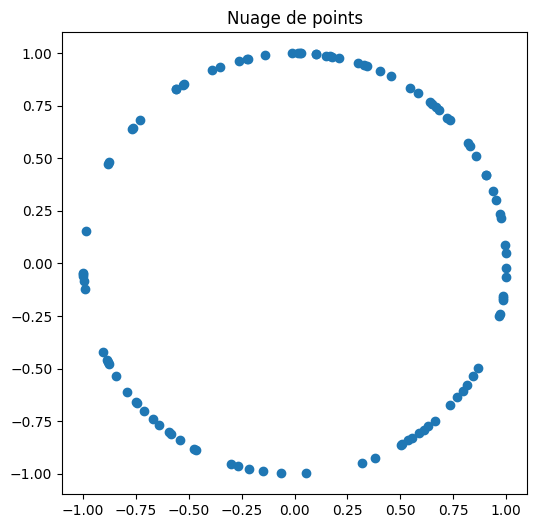

In [2]:
X = np.random.randn(100, 2)
X /= np.linalg.norm(X, axis=1)[:, None].repeat(2, axis=1)


fig = plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1])
plt.title("Nuage de points") and plt.show()

On définit ici les paramètres du problème (dimension n des données d’entrée, ici n=2, et dimension de l’espace latent). Ils pourront être modifiés par la suite ci-besoin.

In [3]:
data_dim = X.shape[-1]
hidden_dim = 10

---
<span style='color:Green'>**Question**</span>

Écrire en utilisant l’interface [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) de PyTorch:

- un générateur $G$ entièrement connecté à 3 couches qui projette un vecteur z de l’espace latent de dimension hidden_dim vers un échantillon de dimension data_dim (dimension des données d’entrée),

- un discriminateur $D$ entièrement connecté à 3 couches qui à partir d’un vecteur de données (réel ou faux) produit en sortie un valeur entre 0 et 1 (obtenue en passant le score dans une sigmoïde).

---

In [4]:
generator = nn.Sequential(
    nn.Linear(hidden_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.Linear(256, data_dim),
    nn.Tanh()  # Utilisation de Tanh pour la génération d'images, ajustez selon vos besoins
)

discriminator = nn.Sequential(
    nn.Linear(data_dim, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()  # Utilisation de la sigmoïde pour obtenir une valeur entre 0 et 1
)

Pour créer le jeu d’apprentissage, torch dispose d’une fonction bien pratique qui permet de transformer automatiquement une matrice d’observation en Dataset. Nous pouvons créer le DataLoader dans la foulée :

In [5]:
from torch.utils import data

dataset = data.TensorDataset(torch.Tensor(X))
dataloader = data.DataLoader(dataset, batch_size=100)

(modifiez le paramètre batch_size si jamais vous ne disposez pas de suffisamment de mémoire ou si les calculs sont trop lents)

L’apprentissage des poids des réseaux $D$ et $G$ se fait par des mises à jour séparées. Nous aurons donc besoin de deux optimiseurs différents, un qui porte sur les paramètres du générateur et l’autre qui portent sur les paramètres du discriminateur :

In [6]:
G_optimizer = torch.optim.Adam(generator.parameters())
D_optimizer = torch.optim.Adam(discriminator.parameters())

---
<span style='color:Green'>**Question**</span>

Compléter la boucle d’apprentissage ci-dessous, et notamment le calcul des fonctions de coût pour le générateur et pour le discriminateur. On rappelle que :

le discriminateur cherche à maximiser $L_D = \log D(x) + \log{(1 - D(\hat{x}))}$ où $x$ sont des données réelles et $\hat{x}$  des données générées ($\hat{x} = G(z)$), c’est-à-dire que la sortie de la sigmoïde du discriminateur doit valoir 1 pour les données réelles et 0 pour les données fausses,

le générateur cherche à minimiser $L_G=\log(1−D(\hat{x}))=\log(1−D(G(z))$, c’est à dire tromper le discriminateur en le poussant à prédire que des données fausses sont réelles.

L’algorithme d’apprentissage du GAN est donc le suivant :

- Tant que la convergence n’est pas atteinte

- Tirer un batch $x$ de données réelles

- Tirer un bruit aléatoire $ z \in \mathcal{N}(0,1)$

- Générer des fausses données $G(z)$

- Générer les labels pour les données réelles et synthétiques

- Calculer la fonction de coût de $G$ sur les données synthétiques

- Faire un pas d’optimisation sur $G$

- Calculer la fonction de coût de $D$ sur les données réelles + fausses

- Faire un pas d’optimisation de $D$

- On rappelle que la méthode .backward() permet de rétropropager les gradients d’un tenseur et que optimizer.step() permet ensuite de réaliser un pas de descente de gradient (mise à jour des poids).

**Attention:** il ne faut pas rétropropager le gradient dans $G$ lorsque vous réalisez une itération sur $D$. Cela peut se faire à l’aide de la méthode .detach() qui permet de signifier à PyTorch que vous n’aurez pas besoin du gradient pour le tenseur concerné.

---

In [7]:
from tqdm.notebook import tqdm, trange

In [8]:
criterion = nn.BCELoss()

for epoch in trange(10000):
    for real_data,in dataloader:  # Assurez-vous de remplacer "dataloader" par votre propre dataloader
        batch_size = real_data.size(0)

        # Échantillonne des codes au hasard dans l'espace latent
        z = torch.randn(batch_size, hidden_dim)

        # Classe "faux" = 0
        fake_labels = torch.zeros(batch_size, 1)

        # Classe "vrai" = 1
        real_labels = torch.ones(batch_size, 1)

        # Entraîne le générateur
        G_optimizer.zero_grad()
        generated_data = generator(z)
        outputs_G = discriminator(generated_data)
        loss_G = criterion(outputs_G, real_labels)
        loss_G.backward()
        G_optimizer.step()

        # Entraîne le discriminateur
        D_optimizer.zero_grad()
        outputs_real = discriminator(real_data)
        outputs_fake = discriminator(generated_data.detach())  # Utilisation de detach() pour ne pas rétropropager dans G
        loss_real = criterion(outputs_real, real_labels)
        loss_fake = criterion(outputs_fake, fake_labels)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        D_optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

---
<span style='color:Green'>**Question**</span>

Tirez aléatoirement des vecteurs z de bruit selon une loi normale. Générez les points associés et visualisez côte à côte le nuage de points réel et le nuage de points synthétique.

---

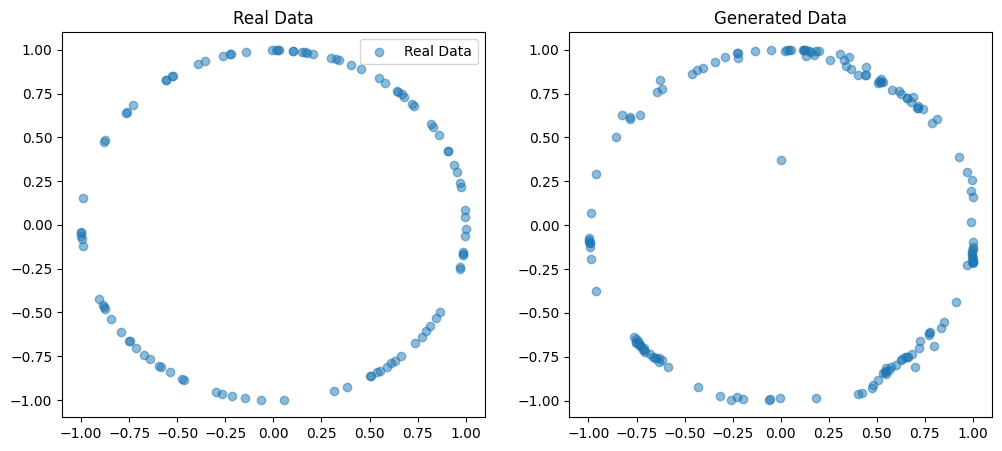

In [9]:
import torch
import matplotlib.pyplot as plt

# Définir une fonction pour générer et visualiser les points synthétiques
def generate_and_visualize(generator, num_points=150):
    # Générer des vecteurs de bruit aléatoires
    z = torch.randn(num_points, hidden_dim)

    # Passer les vecteurs de bruit à travers le générateur
    generated_data = generator(z).detach().numpy()

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Premier sous-graphique pour les données réelles
    axes[0].scatter(real_data[:, 0], real_data[:, 1], label='Real Data', alpha=0.5)
    axes[0].set_title('Real Data')

    # Deuxième sous-graphique pour les données générées
    axes[1].scatter(generated_data[:, 0], generated_data[:, 1], label='Generated Data', alpha=0.5)
    axes[1].set_title('Generated Data')

    # Afficher la légende
    axes[0].legend()
    axes[1].legend

generate_and_visualize(generator)


---
<span style='color:Green'>**Question**</span>

Colorez les points générés en fonction de la classe (“real” ou “fake”) prédite par le discriminateur. On mettera le seuil à 0.5.

---

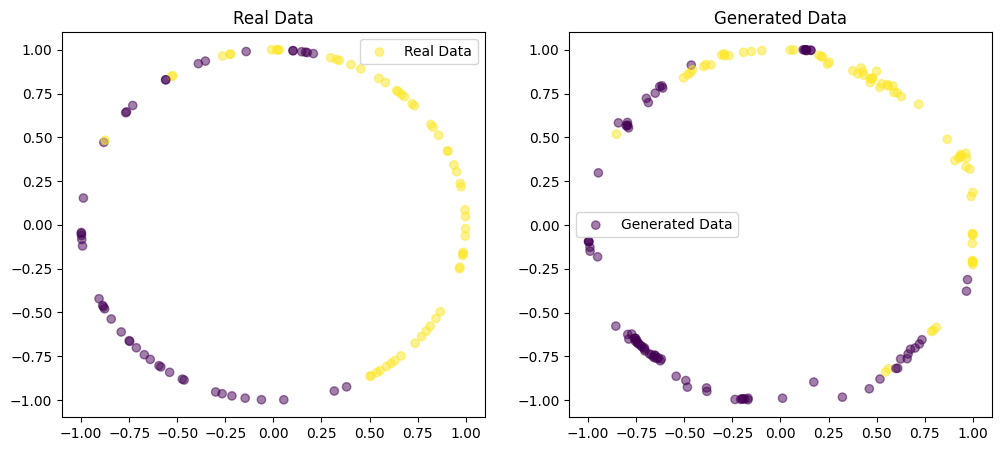

In [10]:
import torch
import matplotlib.pyplot as plt

# Définir une fonction pour générer et visualiser les points synthétiques
def generate_and_visualize(generator, discriminator, num_points=150):
    # Générer des vecteurs de bruit aléatoires
    z = torch.randn(num_points, hidden_dim)

    # Passer les vecteurs de bruit à travers le générateur
    generated_data = generator(z).detach().numpy()

    # Passer les données réelles et générées à travers le discriminateur
    outputs_generated = discriminator(generator(z).detach())

    # Utiliser un seuil de 0.5 pour déterminer la classe prédite
    predicted_real = (outputs_real >= 0.5).numpy()
    predicted_generated = (outputs_generated >= 0.5).numpy()

    # Créer une figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Premier sous-graphique pour les données réelles
    axes[0].scatter(real_data[:, 0], real_data[:, 1], c=predicted_real, label='Real Data', alpha=0.5)
    axes[0].set_title('Real Data')

    # Deuxième sous-graphique pour les données générées
    axes[1].scatter(generated_data[:, 0], generated_data[:, 1], c=predicted_generated, label='Generated Data', alpha=0.5)
    axes[1].set_title('Generated Data')

    # Afficher la légende
    axes[0].legend()
    axes[1].legend()

    # Afficher la figure
    plt.show()

# Utiliser la fonction avec le générateur et le discriminateur actuels
generate_and_visualize(generator, discriminator)


---
<span style='color:Green'>**Question (Optionnelle)**</span>


Repmlaçez le jeu de données $X$ défini plus haut par les deux demi-lunes ou le swiss roll ci-dessous et répondez aux mêmes questions.

---



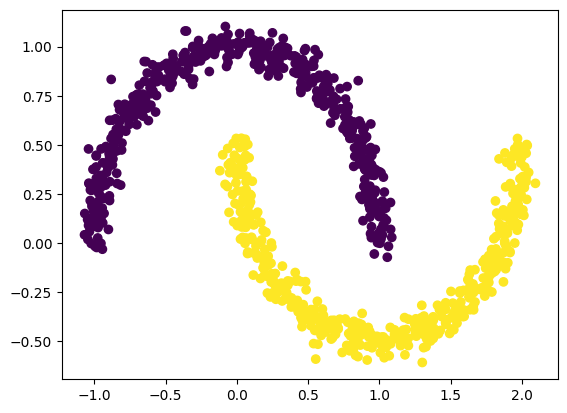

In [11]:
from sklearn import datasets

X, y = datasets.make_moons(n_samples=1000, noise=0.05)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

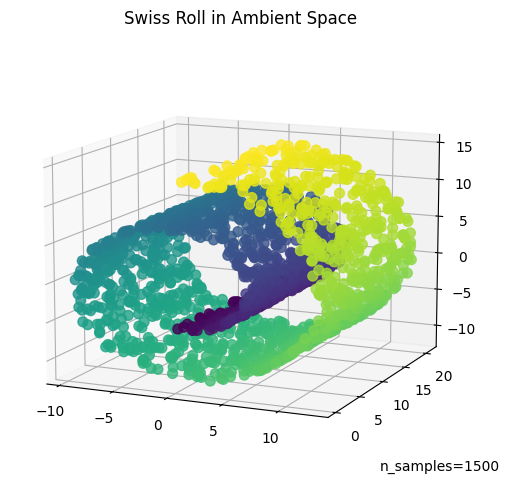

In [12]:
# Générer des données Swiss Roll
X, y = datasets.make_swiss_roll(n_samples=2000, noise=0.05)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter( X[:, 0], X[:, 1], X[:, 2], c=y, s=50, alpha=0.8)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1500", transform=ax.transAxes)

---
<span style='color:#0d5874'> **Exercice 2 : Génération de chiffres manuscrits avec MNIST** </span>

---

On va reprendre le code précédent et l’adapter à la dimensionalité de MNIST. On rappelle qu’une image de MNIST est de dimensions 28×28, c’est-à-dire un vecteur de dimension 784 une fois aplati. On va implémenter un GAN conditionnel sur MNIST. On utilisera comme vecteur de conditionnement y la classe du chiffre sous forme de vecteur suivant l’encodage one-hot.

On commence par récupérer charger le jeu de données :


In [13]:
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_mnist = MNIST(root="./data/", train=True, download=True, transform=ToTensor())
mnist_loader = data.DataLoader(train_mnist, shuffle=True, batch_size=128, num_workers=1)
device = "cuda" if torch.cuda.is_available else "cpu" # Utilise le GPU si disponible

100%|██████████| 9912422/9912422 [00:00<00:00, 11297959.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33124335.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26799963.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6360777.55it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



---
<span style='color:Green'>**Question**</span>

On voudrait que le générateur produise des images de 28x28 pixels, et donc un vecteur applati de 784. On utilisera 100 comme dimension de l'espace latent + 10 qui correspond à l'encodage one-hot du label.  

On définit le génerateur et discriminateur comme suit :

Générateur :

1. Linear(in_features=hidden_dim + 10, out_features=1024) ReLU()
2. Linear(in_features=1024, out_features=1024) ReLU()
3. Linear(in_features=1024, out_features=data_dim) Sigmoid()


Discriminateur :

1. Linear(in_features=data_dim + 10, out_features=64) LeakyReLU() Dropout()
2. Linear(in_features=64, out_features=64) Dropout() LeakyReLU()
3. Linear(in_features=64, out_features=1) Sigmoid()


---


In [14]:

# Dimensions
hidden_dim = 100
label_dim = 10  # Dimension de l'encodage one-hot du label
data_dim = 784

# Générateur
generator = nn.Sequential(
    nn.Linear(hidden_dim + label_dim, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, data_dim),
    nn.Sigmoid()
)

# Discriminateur
discriminator = nn.Sequential(
    nn.Linear(data_dim + label_dim, 64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
)


---
<span style='color:Green'>**Question**</span>

- A quoi sert l'utilisation des Dropout() dans le discriminateur?

Dropout() est utilisé dans le discriminateur des GANs pour prévenir le surajustement en désactivant aléatoirement des neurones pendant l'entraînement, favorisant ainsi une meilleure généralisation du modèle.
- C'est quoi la différence entre une ReLU() et la LeakyReLU() ?

Définissez les optimiseurs dont on a besoin pour l'apprentissage. Le learning rate est à choisir judicieusement.

ReLU() met à zéro les valeurs négatives, tandis que LeakyReLU() permet un faible flux de gradient pour les entrées négatives, évitant ainsi le problème de "mort des neurones" associé à ReLU en cas de gradients nuls.

---

In [15]:
G_optimizer =torch.optim.Adam(generator.parameters(), 0.0002)
D_optimizer =torch.optim.Adam(discriminator.parameters(), 0.0002)

On vous fournit la fonction plot_image qui prend en paramètre le générateur, un bruit z et le chiffre qu'on veut générer (0 par défaut). Dans cette fonction, on concatène le label du digit qu'on veut générer au z sous forme encodée. On met ce bruit en entrée de notre générateur qui génère des images de zéro par défaut. Le résultat est réorganisé sous une forme 2D.

**Note :** le z devra être de taille 10 x hidden_dim, on génère 10 images à la fois

In [16]:
def plot_images(generator, z, digit=0):
    c = torch.zeros((10, 10))
    c[:, digit] = 1.
    z = torch.concat((z, c), dim=1)
    z = z.to(device)
    with torch.no_grad():
        samples = generator(z)
    fig, axis = plt.subplots(1, 10, figsize=(15, 10))
    for idx, sample in enumerate(samples):
        sample = sample.to("cpu").numpy().reshape(28, 28)
        axis[idx].imshow(sample, cmap="gray")
        axis[idx].axis("off")
    plt.show()

---
<span style='color:Green'>**Question**</span>

Compléter la boucle d'apprentissage ci-dessous. Vous pouvez utiliser la fonction ‘F.one_hot‘ pour l'encodage des labels. Le processus est le même que tout à l'heure.

Pour chaque epoch, on affiche le résultat du génerateur appliqué au z_display.

---

Epoch 31; Discriminator: 1.288, Generator: 0.740


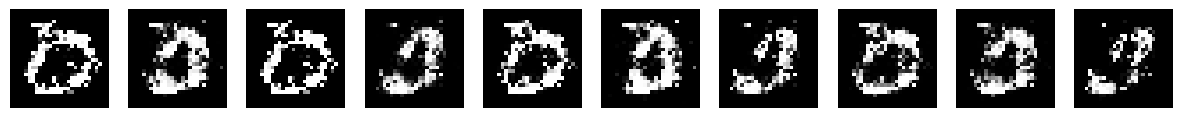

Epoch 32; Discriminator: 1.344, Generator: 0.760


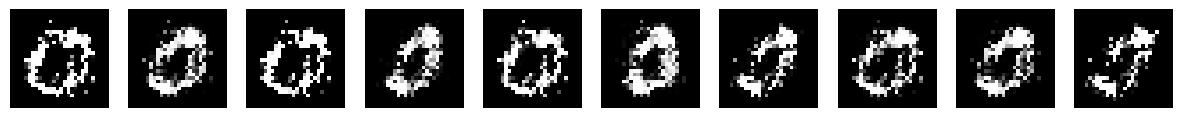

Epoch 33; Discriminator: 1.361, Generator: 0.709


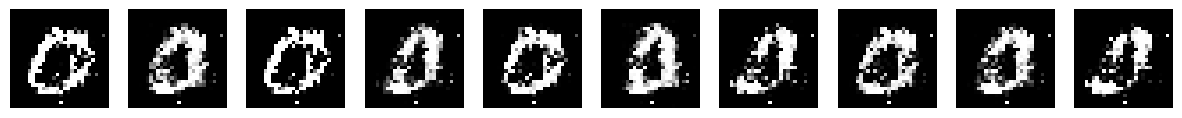

Epoch 34; Discriminator: 1.379, Generator: 0.752


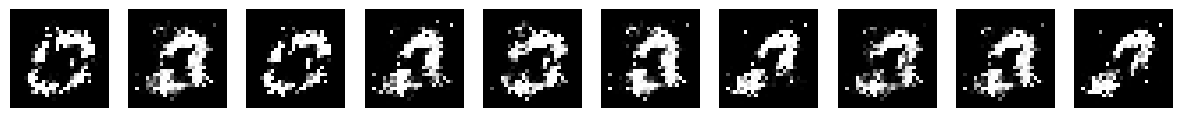

Epoch 35; Discriminator: 1.200, Generator: 0.760


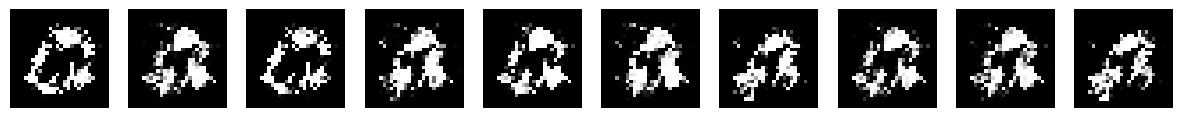

Epoch 36; Discriminator: 1.280, Generator: 0.708


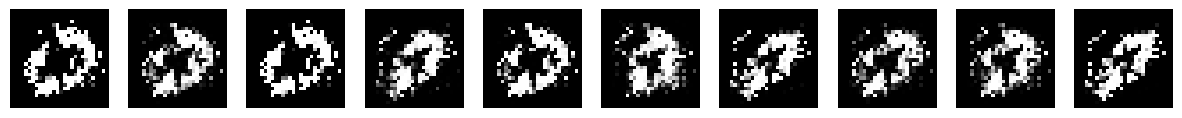

Epoch 37; Discriminator: 1.226, Generator: 0.737


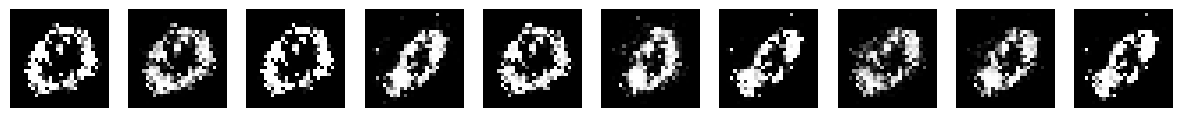

Epoch 38; Discriminator: 1.390, Generator: 0.716


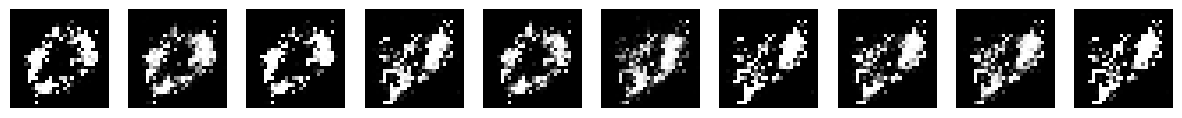

Epoch 39; Discriminator: 1.407, Generator: 0.752


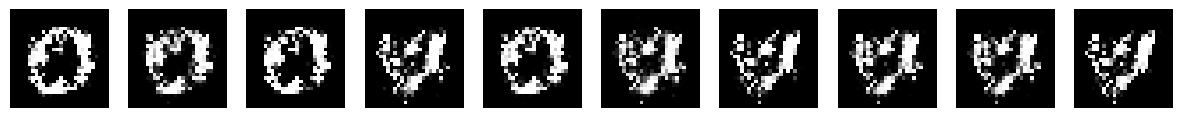

Epoch 40; Discriminator: 1.287, Generator: 0.719


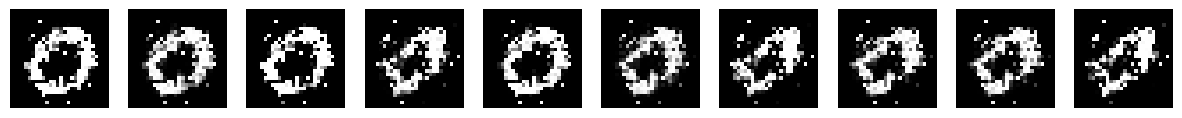

Epoch 41; Discriminator: 1.360, Generator: 0.751


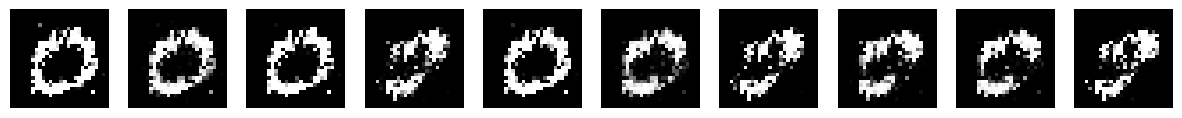

Epoch 42; Discriminator: 1.275, Generator: 0.862


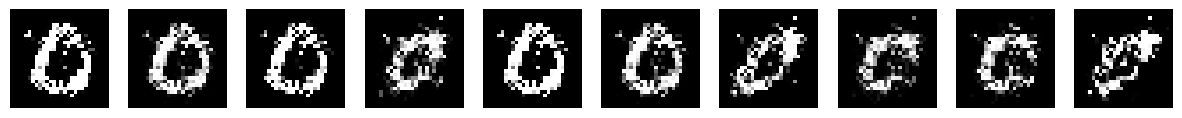

Epoch 43; Discriminator: 1.243, Generator: 0.907


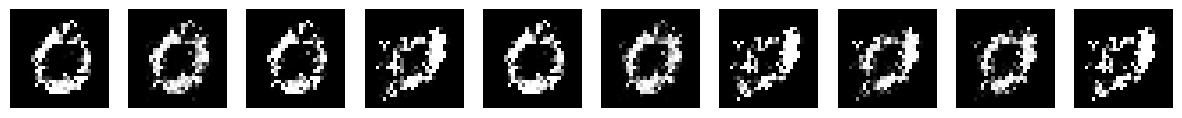

Epoch 44; Discriminator: 1.278, Generator: 0.760


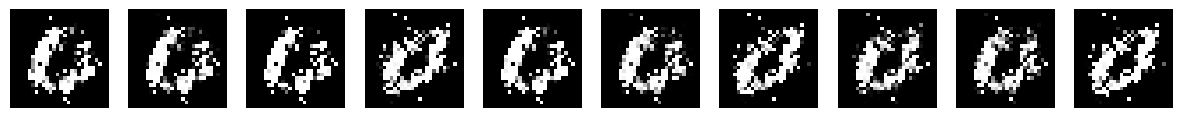

Epoch 45; Discriminator: 1.331, Generator: 0.814


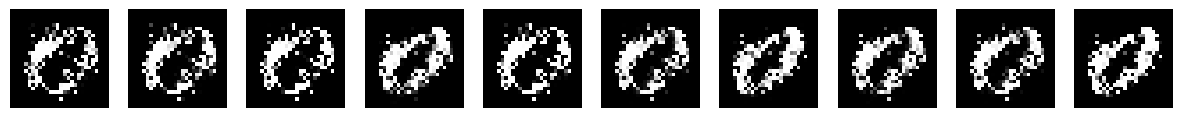

Epoch 46; Discriminator: 1.174, Generator: 0.755


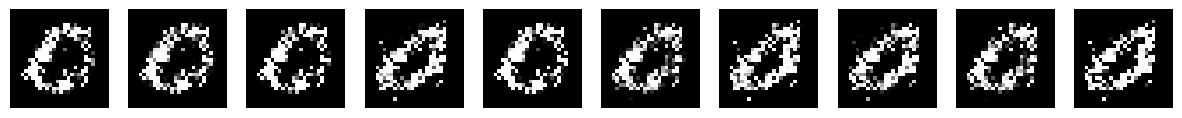

Epoch 47; Discriminator: 1.220, Generator: 0.785


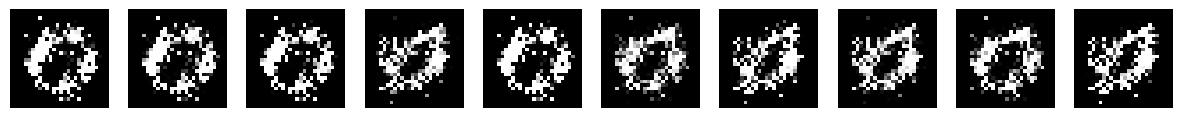

Epoch 48; Discriminator: 1.401, Generator: 0.784


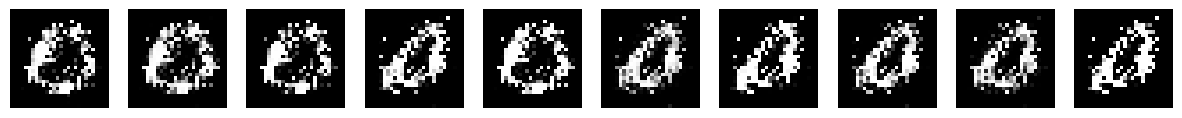

Epoch 49; Discriminator: 1.375, Generator: 0.757


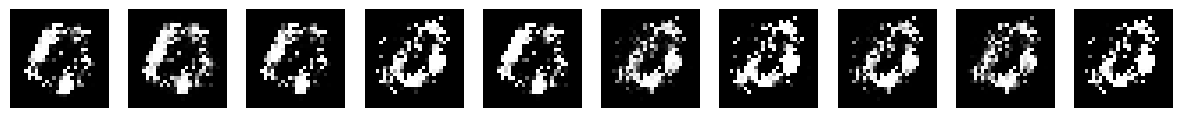

Epoch 50; Discriminator: 1.399, Generator: 0.733


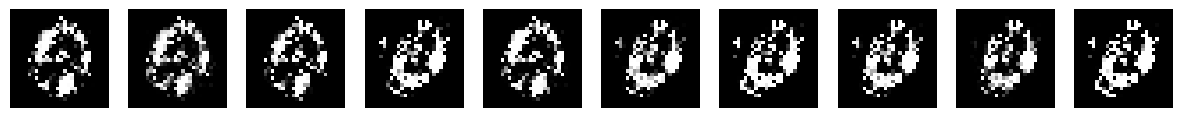

Epoch 51; Discriminator: 1.373, Generator: 0.732


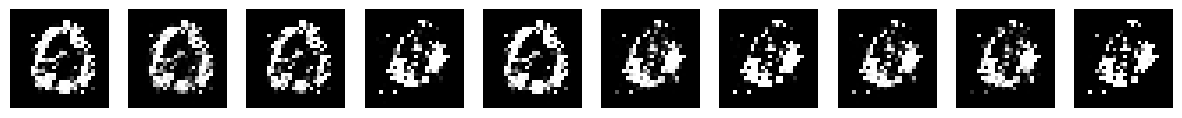

Epoch 52; Discriminator: 1.359, Generator: 0.753


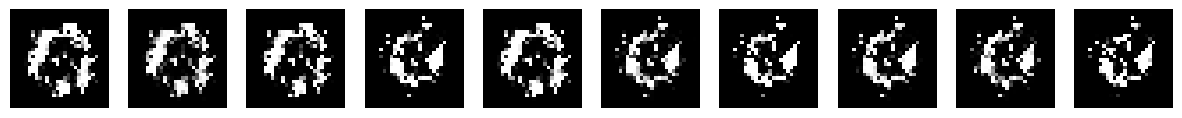

Epoch 53; Discriminator: 1.317, Generator: 0.739


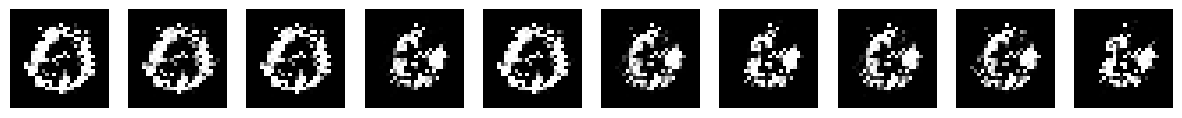

Epoch 54; Discriminator: 1.323, Generator: 0.781


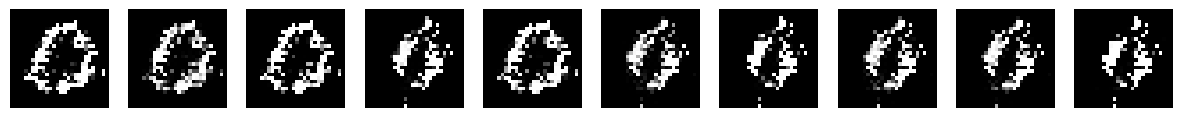

Epoch 55; Discriminator: 1.442, Generator: 0.803


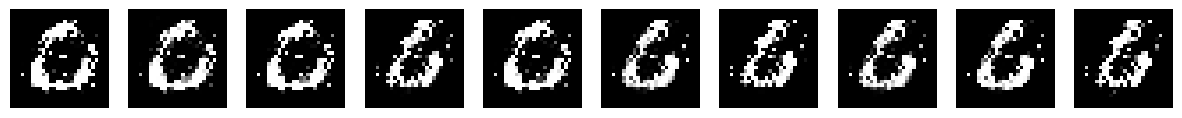

Epoch 56; Discriminator: 1.341, Generator: 0.813


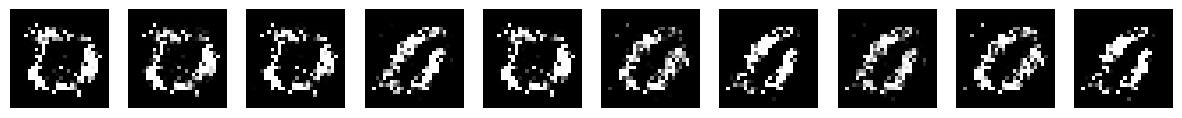

Epoch 57; Discriminator: 1.377, Generator: 0.767


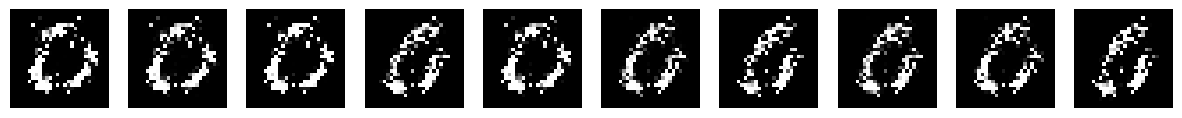

Epoch 58; Discriminator: 1.326, Generator: 0.763


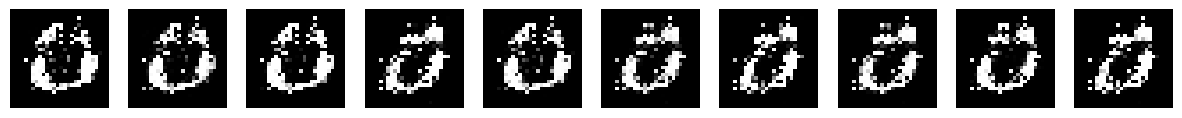

Epoch 59; Discriminator: 1.324, Generator: 0.844


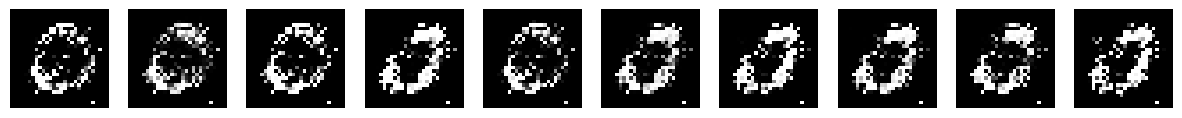

Epoch 60; Discriminator: 1.323, Generator: 0.817


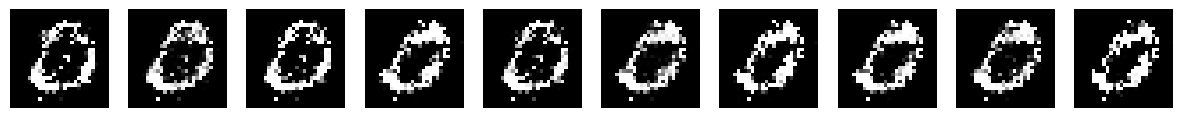

Epoch 61; Discriminator: 1.401, Generator: 0.788


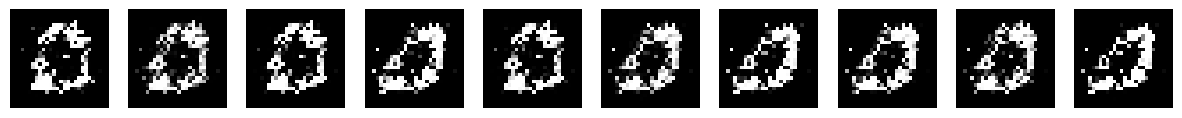

Epoch 62; Discriminator: 1.235, Generator: 0.811


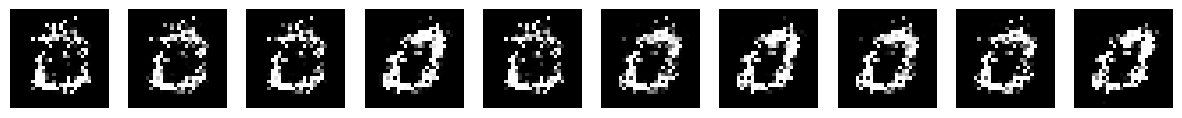

Epoch 63; Discriminator: 1.244, Generator: 0.784


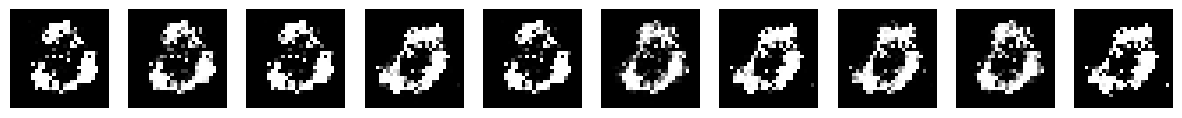

Epoch 64; Discriminator: 1.324, Generator: 0.771


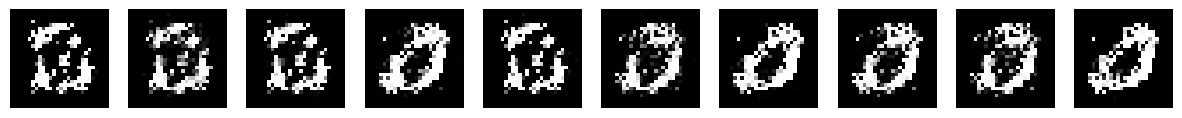

Epoch 65; Discriminator: 1.350, Generator: 0.759


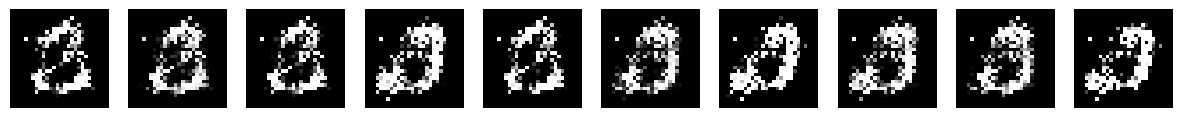

Epoch 66; Discriminator: 1.343, Generator: 0.787


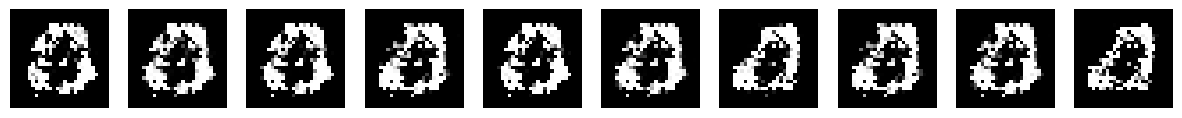

Epoch 67; Discriminator: 1.307, Generator: 0.762


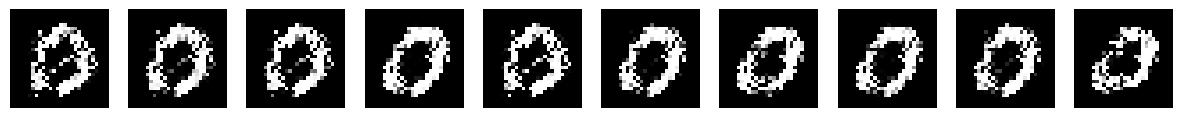

Epoch 68; Discriminator: 1.387, Generator: 0.734


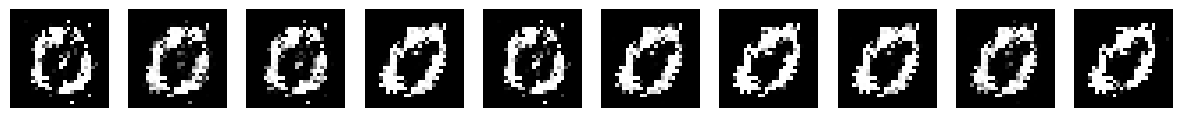

Epoch 69; Discriminator: 1.354, Generator: 0.708


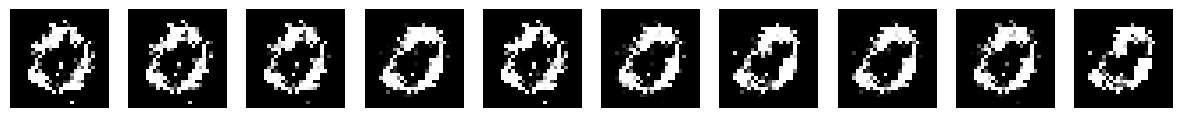

Epoch 70; Discriminator: 1.297, Generator: 0.782


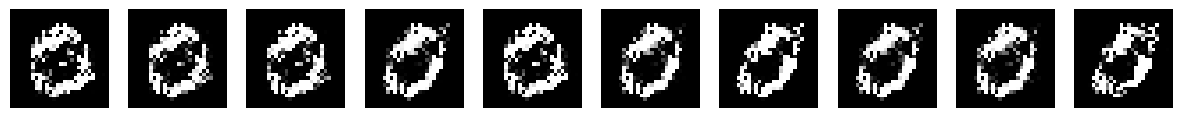

Epoch 71; Discriminator: 1.221, Generator: 0.768


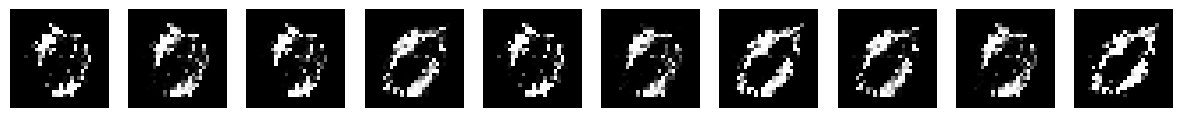

Epoch 72; Discriminator: 1.393, Generator: 0.792


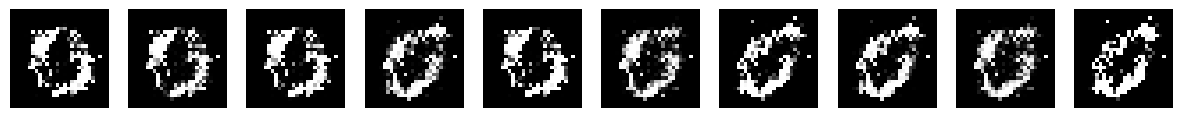

Epoch 73; Discriminator: 1.333, Generator: 0.749


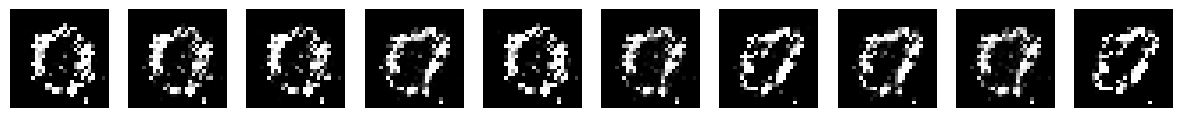

Epoch 74; Discriminator: 1.317, Generator: 0.770


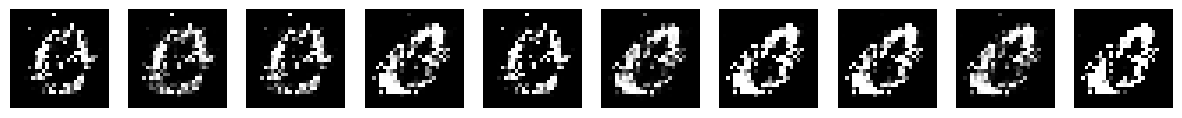

Epoch 75; Discriminator: 1.335, Generator: 0.789


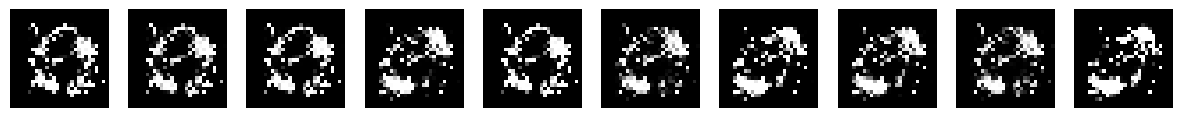

Epoch 76; Discriminator: 1.377, Generator: 0.748


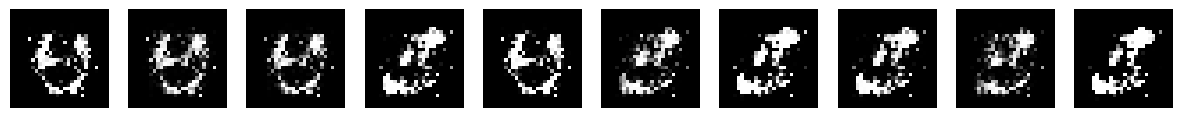

Epoch 77; Discriminator: 1.397, Generator: 0.745


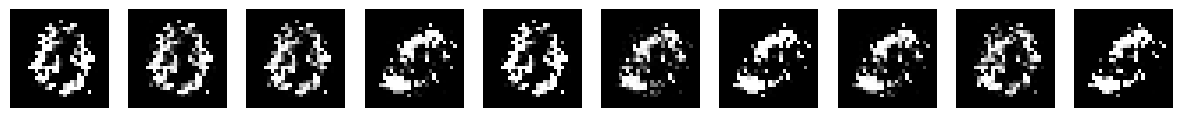

Epoch 78; Discriminator: 1.158, Generator: 0.777


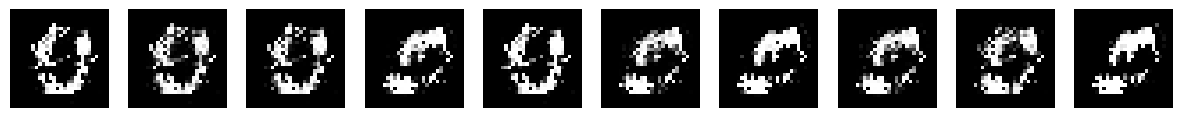

Epoch 79; Discriminator: 1.274, Generator: 0.861


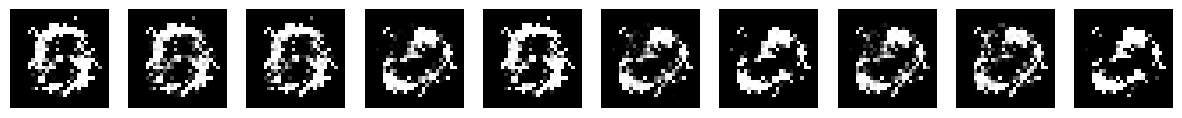

Epoch 80; Discriminator: 1.264, Generator: 0.846


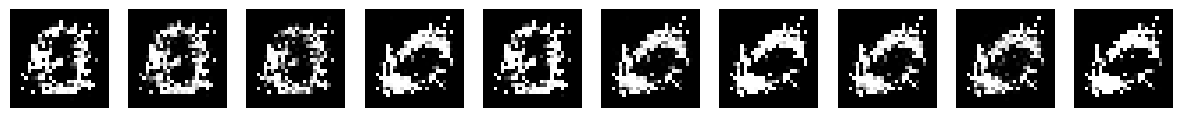

Epoch 81; Discriminator: 1.205, Generator: 0.920


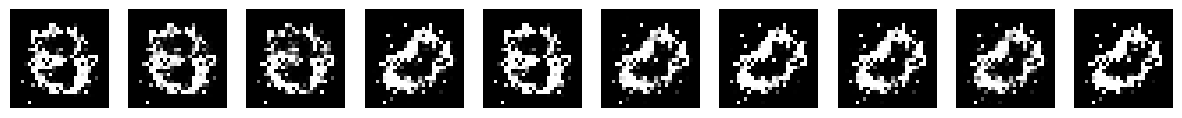

Epoch 82; Discriminator: 1.329, Generator: 0.859


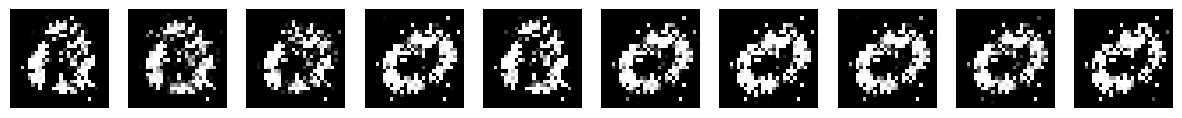

Epoch 83; Discriminator: 1.382, Generator: 0.763


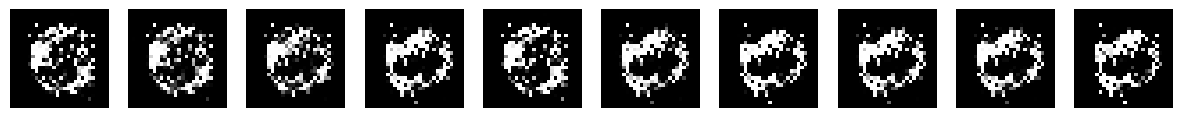

Epoch 84; Discriminator: 1.310, Generator: 0.783


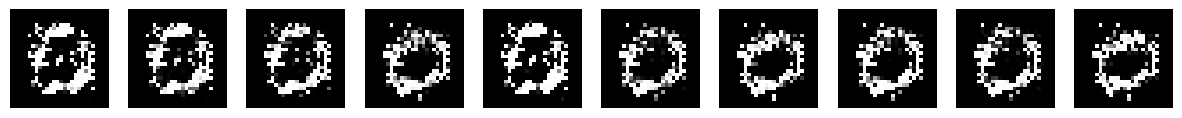

Epoch 85; Discriminator: 1.418, Generator: 0.770


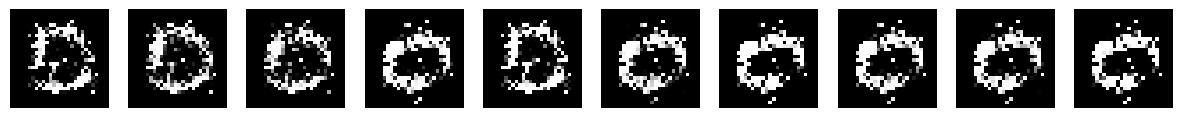

Epoch 86; Discriminator: 1.325, Generator: 0.811


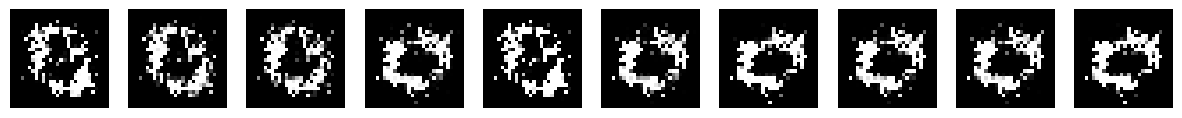

Epoch 87; Discriminator: 1.187, Generator: 0.806


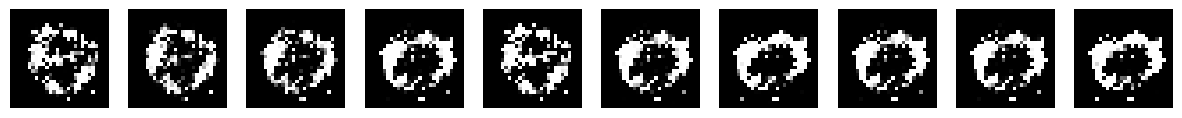

Epoch 88; Discriminator: 1.235, Generator: 0.815


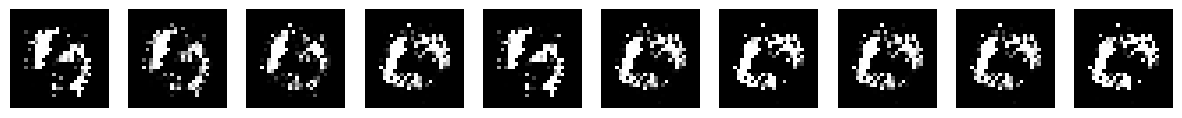

Epoch 89; Discriminator: 1.289, Generator: 0.867


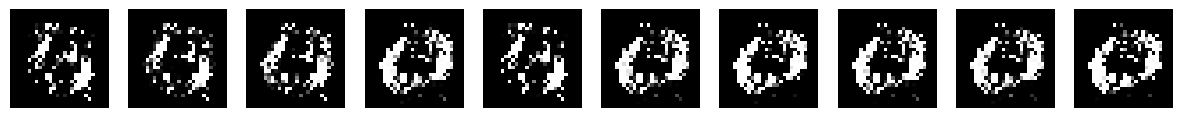

Epoch 90; Discriminator: 1.298, Generator: 0.821


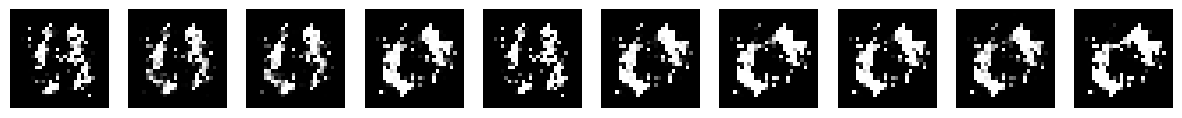

Epoch 91; Discriminator: 1.327, Generator: 0.777


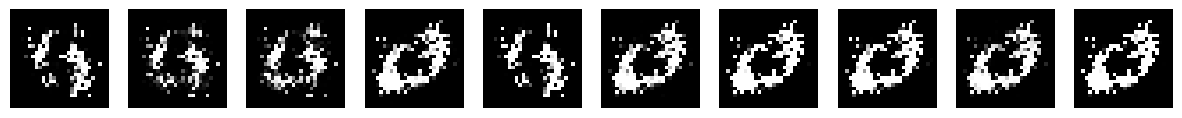

Epoch 92; Discriminator: 1.232, Generator: 0.812


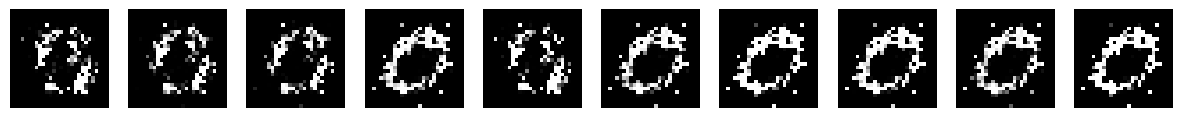

Epoch 93; Discriminator: 1.295, Generator: 0.809


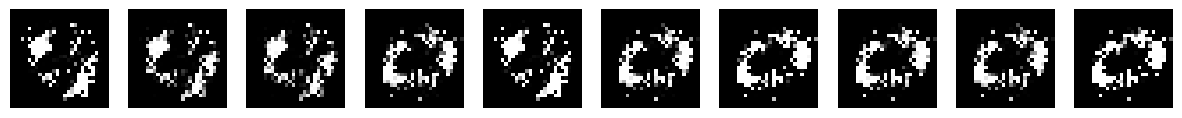

Epoch 94; Discriminator: 1.289, Generator: 0.879


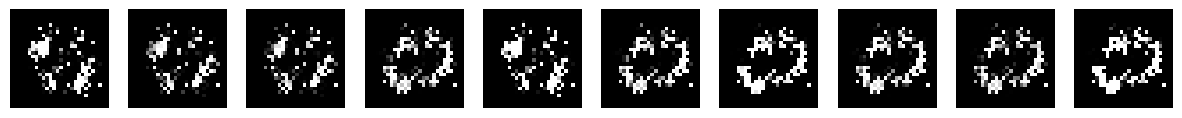

Epoch 95; Discriminator: 1.245, Generator: 0.823


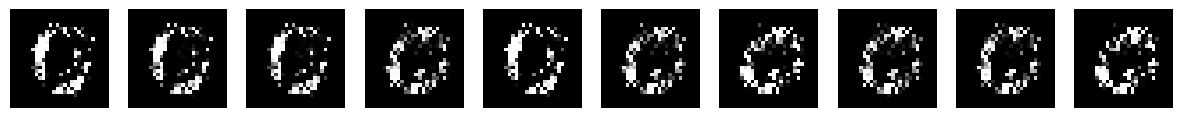

Epoch 96; Discriminator: 1.361, Generator: 0.779


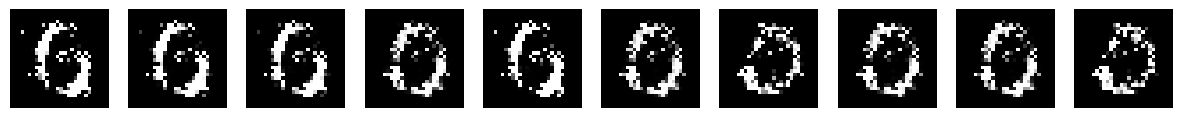

Epoch 97; Discriminator: 1.277, Generator: 0.795


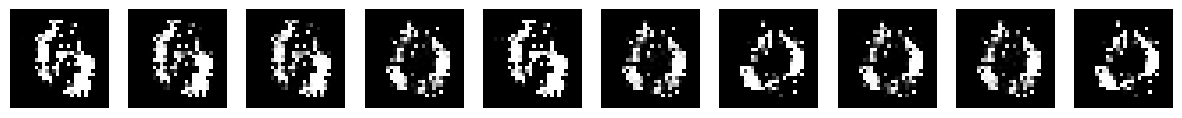

Epoch 98; Discriminator: 1.207, Generator: 0.790


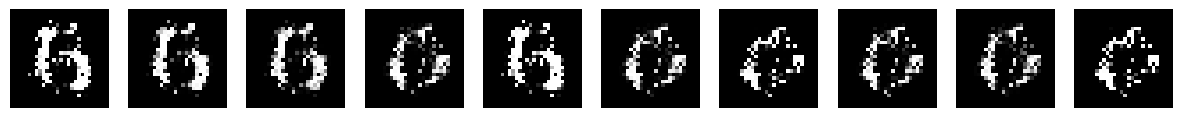

Epoch 99; Discriminator: 1.089, Generator: 0.923


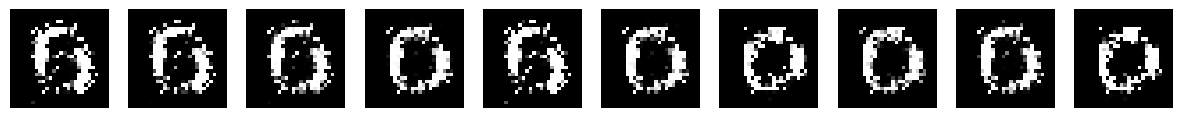

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0; Discriminator: 1.063, Generator: 0.996


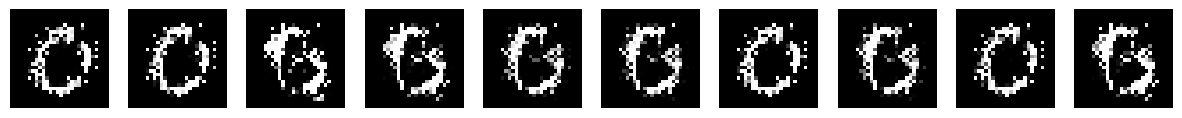

Epoch 1; Discriminator: 1.309, Generator: 0.872


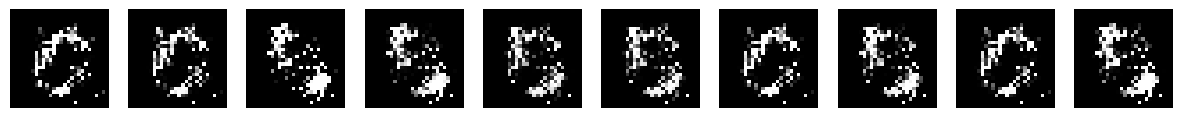

Epoch 2; Discriminator: 1.212, Generator: 0.826


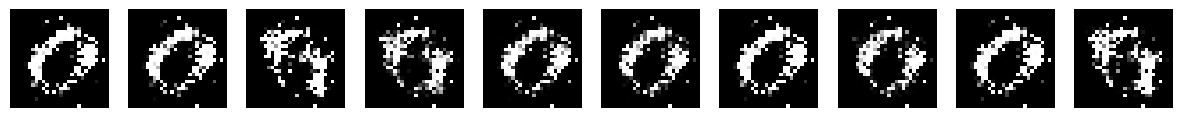

Epoch 3; Discriminator: 1.348, Generator: 0.830


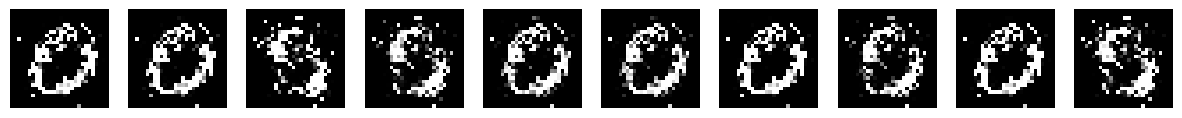

Epoch 4; Discriminator: 1.172, Generator: 0.860


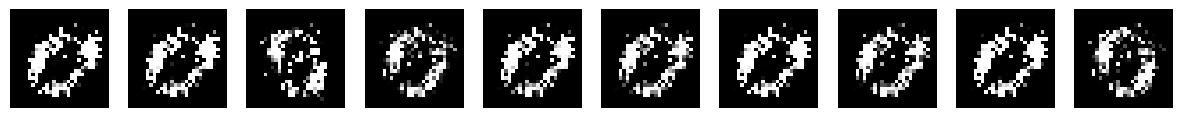

Epoch 5; Discriminator: 1.207, Generator: 0.822


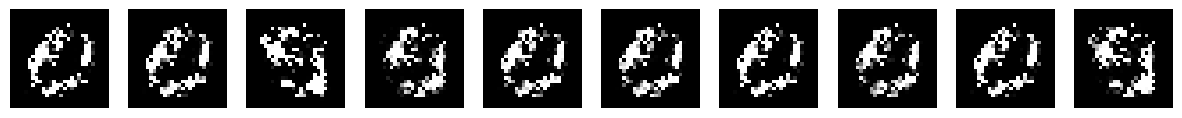

Epoch 6; Discriminator: 1.317, Generator: 0.843


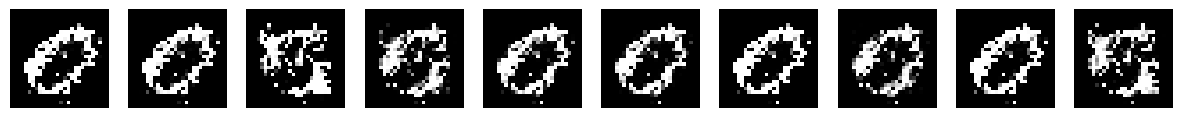

Epoch 7; Discriminator: 1.356, Generator: 0.862


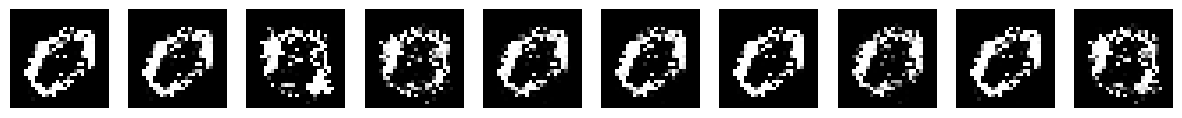

Epoch 8; Discriminator: 1.383, Generator: 0.815


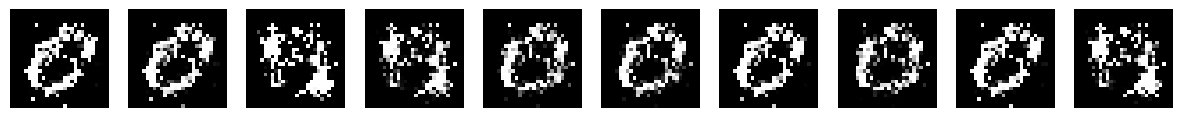

Epoch 9; Discriminator: 1.286, Generator: 0.746


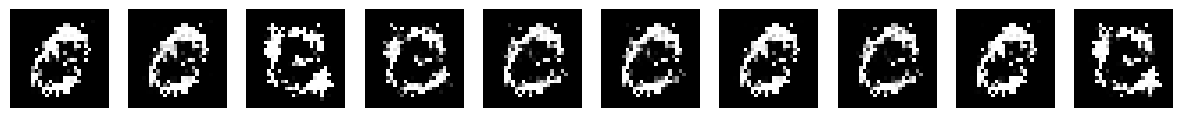

Epoch 10; Discriminator: 1.339, Generator: 0.813


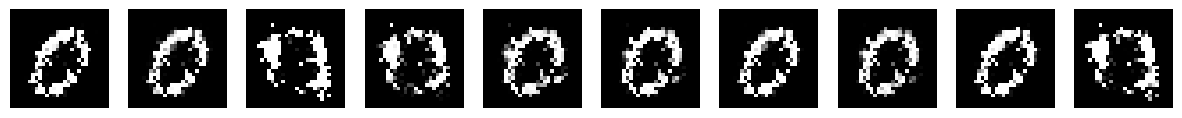

Epoch 11; Discriminator: 1.330, Generator: 0.748


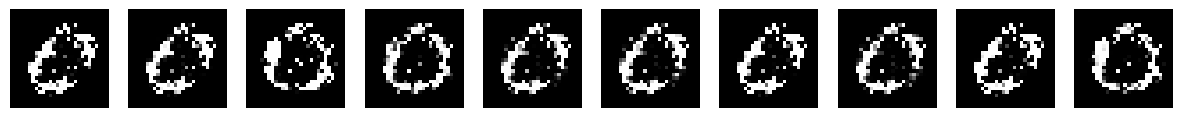

Epoch 12; Discriminator: 1.276, Generator: 0.780


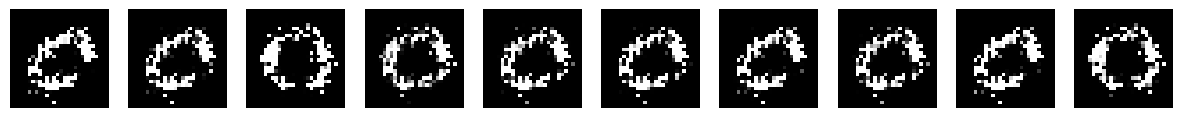

Epoch 13; Discriminator: 1.288, Generator: 0.795


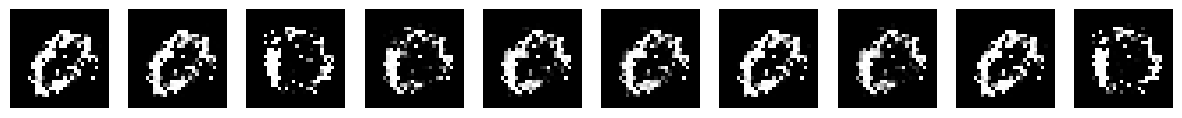

Epoch 14; Discriminator: 1.350, Generator: 0.793


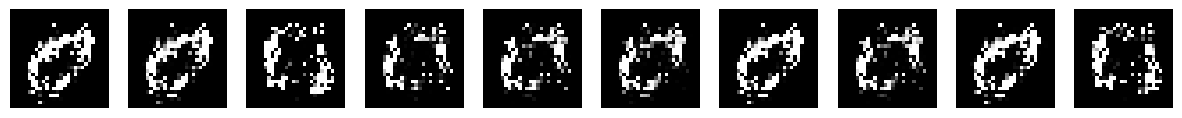

Epoch 15; Discriminator: 1.334, Generator: 0.815


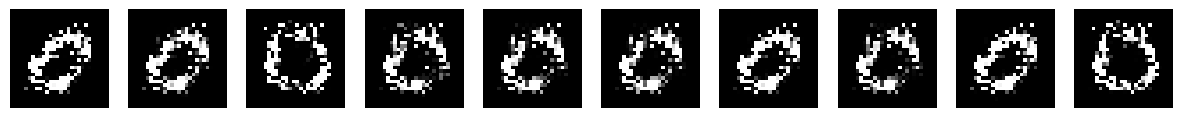

Epoch 16; Discriminator: 1.289, Generator: 0.864


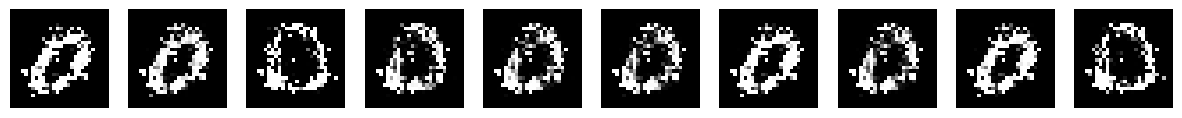

Epoch 17; Discriminator: 1.126, Generator: 0.870


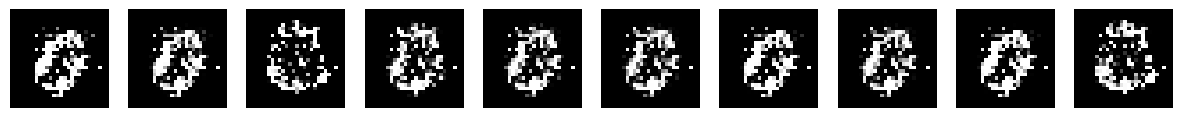

Epoch 18; Discriminator: 1.131, Generator: 0.926


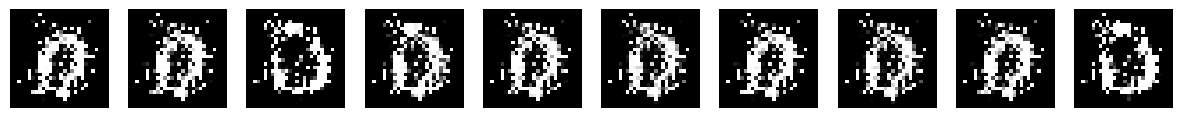

Epoch 19; Discriminator: 1.318, Generator: 0.898


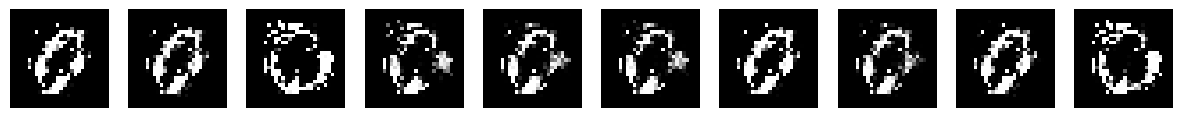

Epoch 20; Discriminator: 1.336, Generator: 0.880


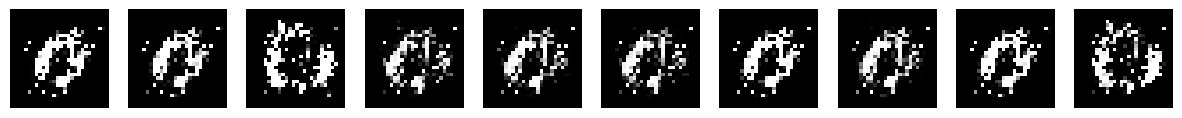

Epoch 21; Discriminator: 1.329, Generator: 0.806


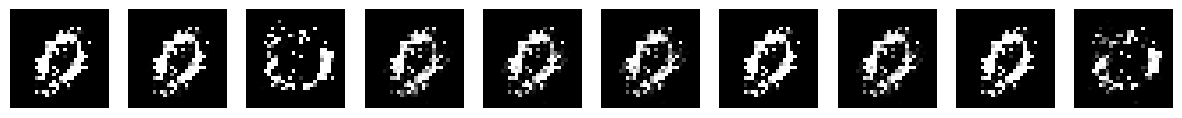

Epoch 22; Discriminator: 1.318, Generator: 0.801


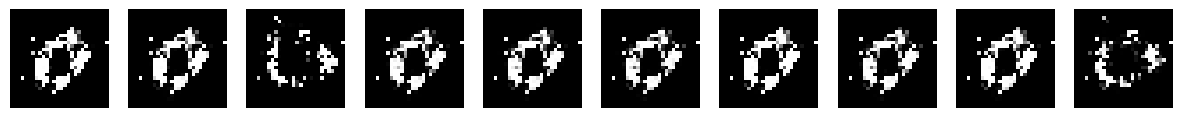

Epoch 23; Discriminator: 1.173, Generator: 0.846


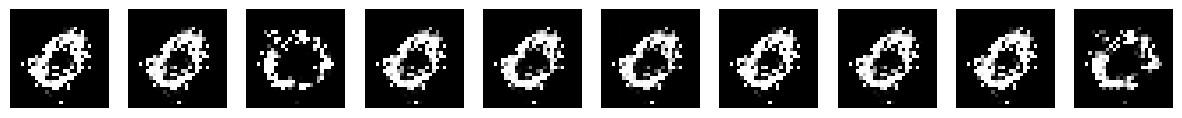

Epoch 24; Discriminator: 1.354, Generator: 0.778


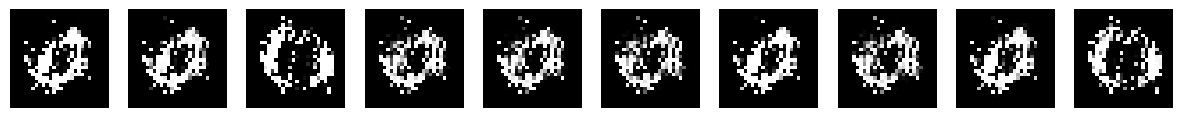

Epoch 25; Discriminator: 1.389, Generator: 0.807


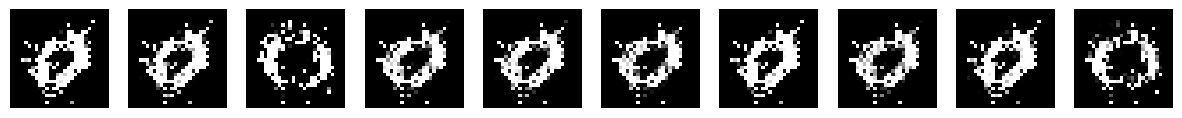

Epoch 26; Discriminator: 1.363, Generator: 0.781


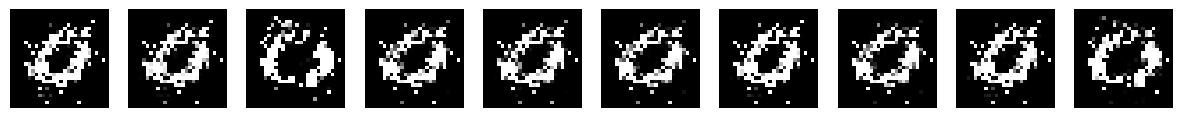

Epoch 27; Discriminator: 1.381, Generator: 0.768


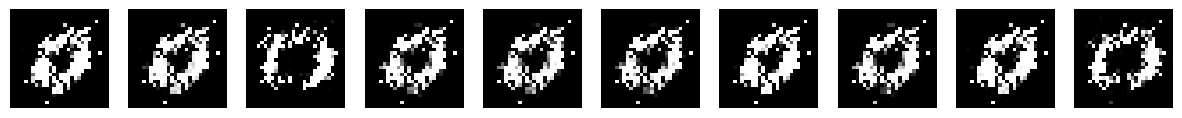

Epoch 28; Discriminator: 1.356, Generator: 0.747


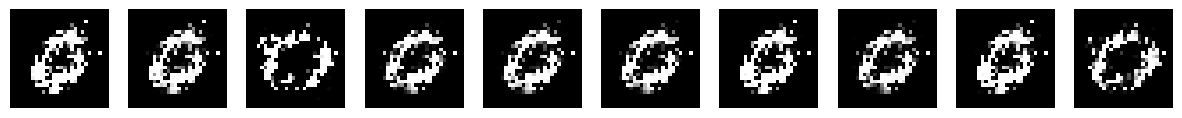

Epoch 29; Discriminator: 1.326, Generator: 0.769


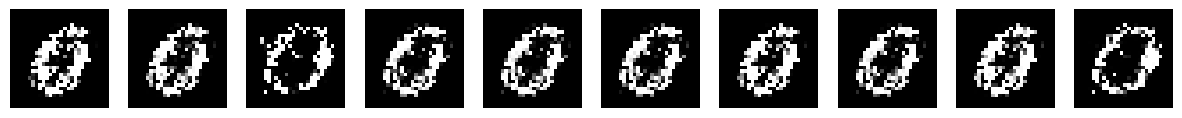

Epoch 30; Discriminator: 1.248, Generator: 0.827


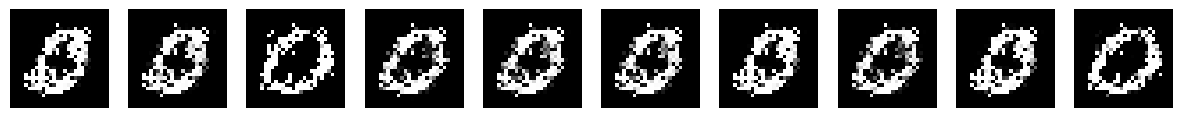

Epoch 31; Discriminator: 1.184, Generator: 0.780


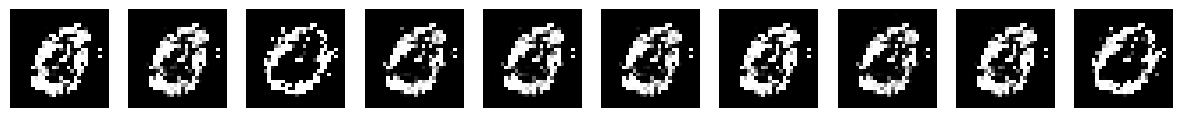

Epoch 32; Discriminator: 1.086, Generator: 0.849


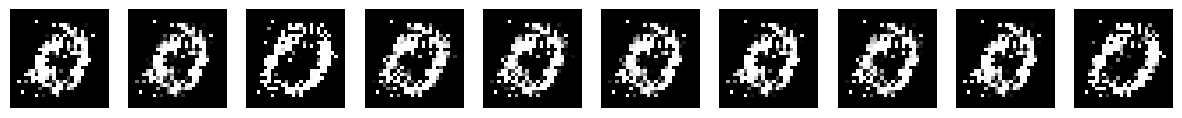

Epoch 33; Discriminator: 1.195, Generator: 0.843


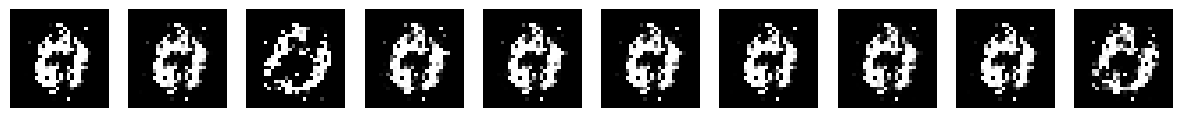

Epoch 34; Discriminator: 1.332, Generator: 0.785


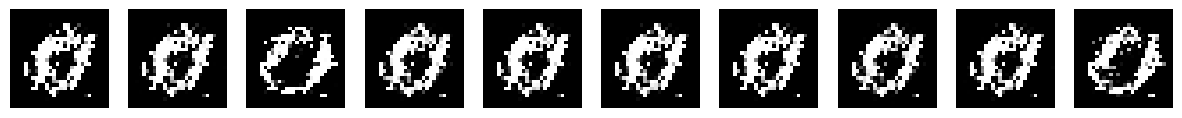

Epoch 35; Discriminator: 1.430, Generator: 0.920


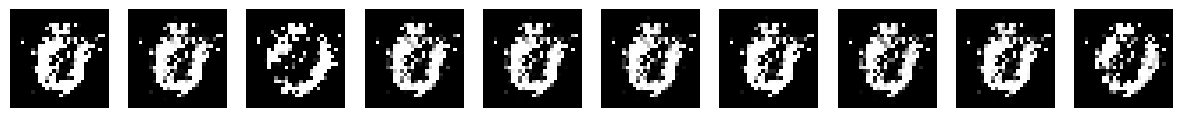

Epoch 36; Discriminator: 1.355, Generator: 0.812


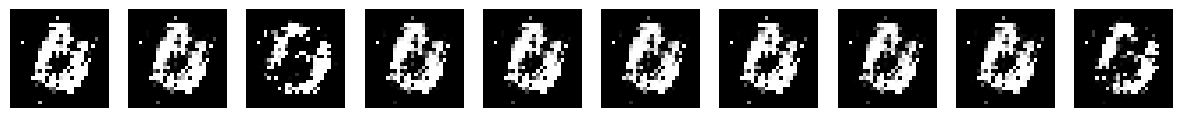

Epoch 37; Discriminator: 1.171, Generator: 0.785


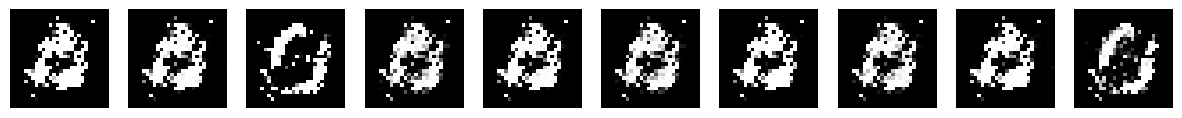

Epoch 38; Discriminator: 1.321, Generator: 0.797


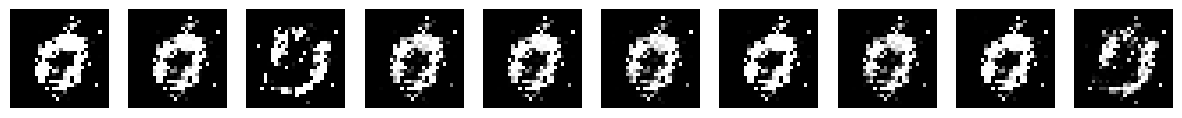

Epoch 39; Discriminator: 1.272, Generator: 0.852


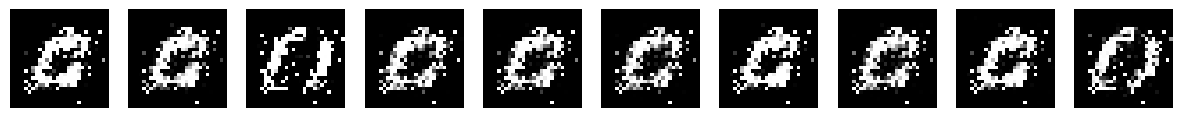

Epoch 40; Discriminator: 1.215, Generator: 0.812


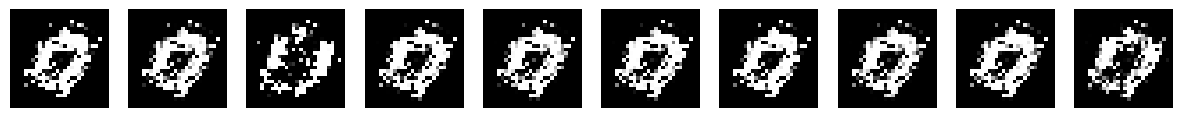

Epoch 41; Discriminator: 1.306, Generator: 0.789


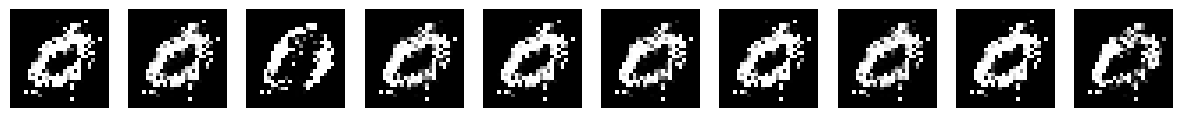

Epoch 42; Discriminator: 1.248, Generator: 0.914


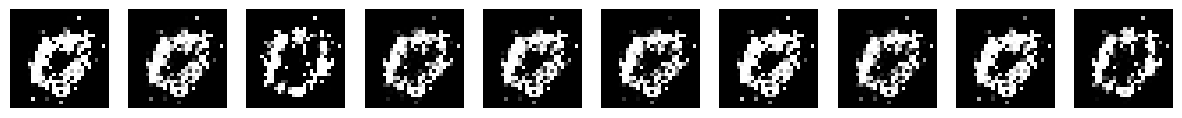

Epoch 43; Discriminator: 1.253, Generator: 0.932


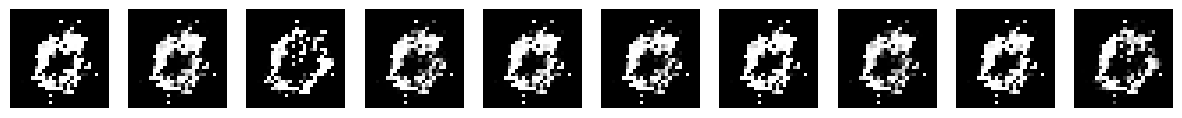

Epoch 44; Discriminator: 1.105, Generator: 0.980


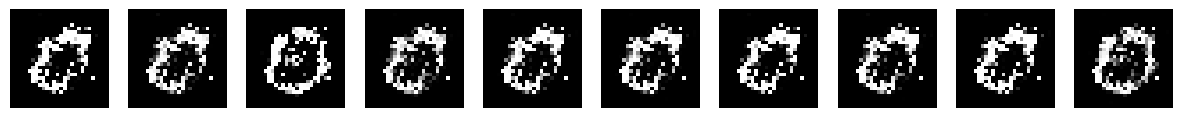

Epoch 45; Discriminator: 1.194, Generator: 0.900


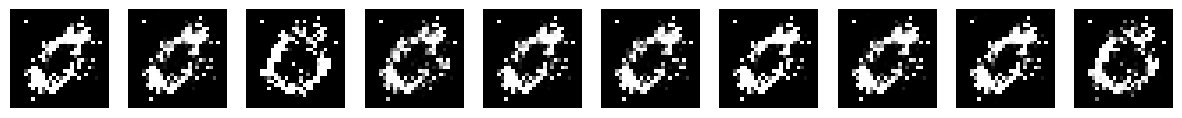

Epoch 46; Discriminator: 0.997, Generator: 1.088


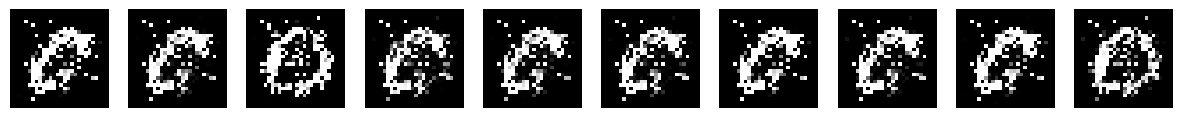

Epoch 47; Discriminator: 1.074, Generator: 0.883


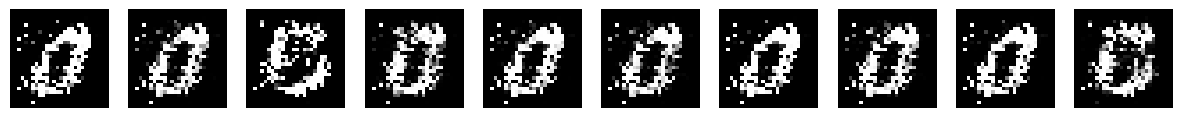

Epoch 48; Discriminator: 1.195, Generator: 0.936


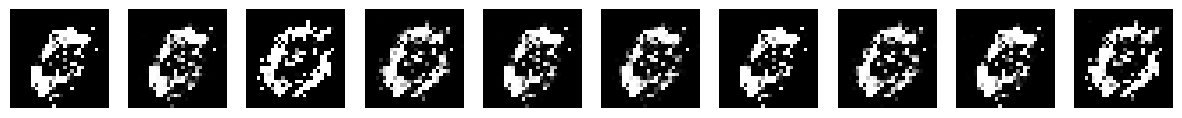

Epoch 49; Discriminator: 1.254, Generator: 0.843


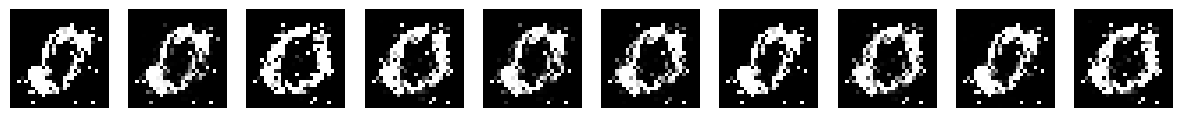

Epoch 50; Discriminator: 1.375, Generator: 0.849


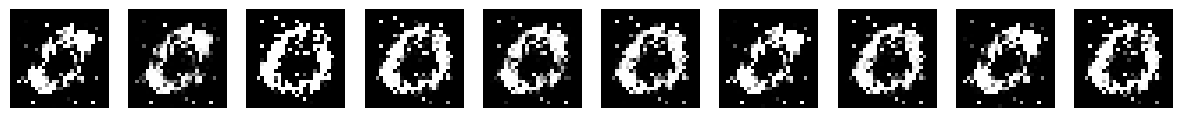

Epoch 51; Discriminator: 1.334, Generator: 0.804


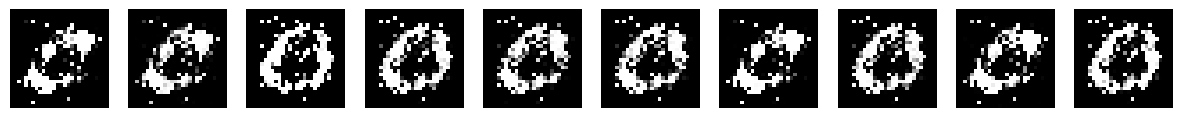

Epoch 52; Discriminator: 1.415, Generator: 0.762


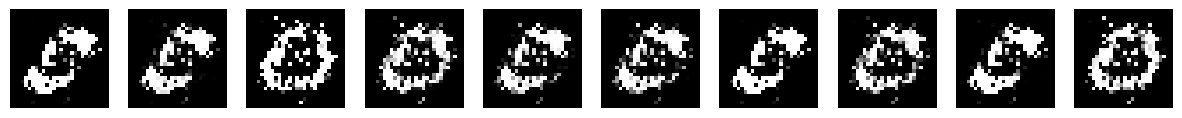

Epoch 53; Discriminator: 1.414, Generator: 0.733


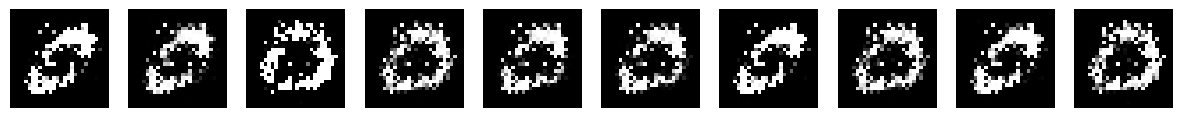

Epoch 54; Discriminator: 1.304, Generator: 0.748


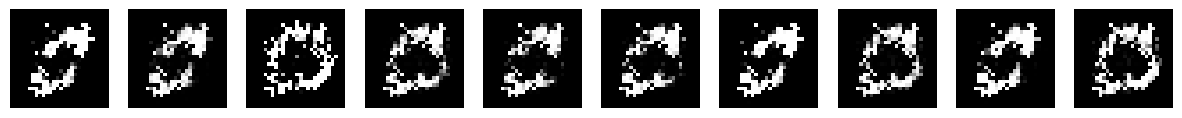

Epoch 55; Discriminator: 1.327, Generator: 0.830


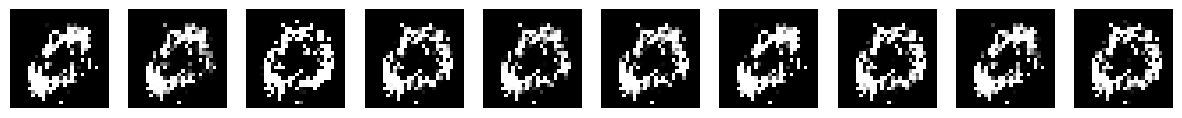

Epoch 56; Discriminator: 1.245, Generator: 0.788


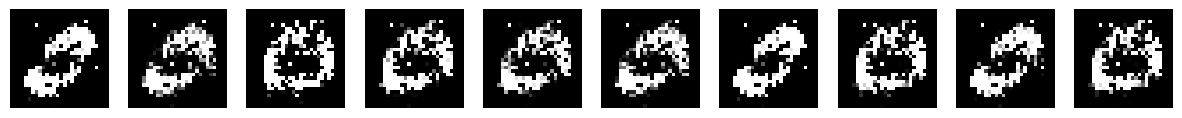

Epoch 57; Discriminator: 1.195, Generator: 0.811


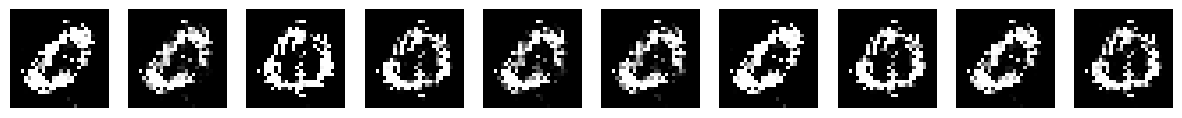

Epoch 58; Discriminator: 1.157, Generator: 0.895


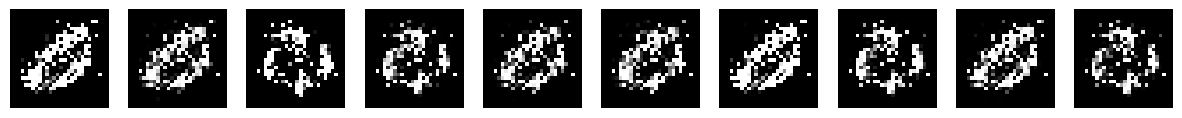

Epoch 59; Discriminator: 1.259, Generator: 0.866


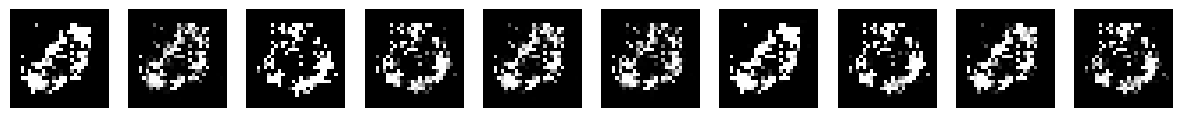

Epoch 60; Discriminator: 1.257, Generator: 0.884


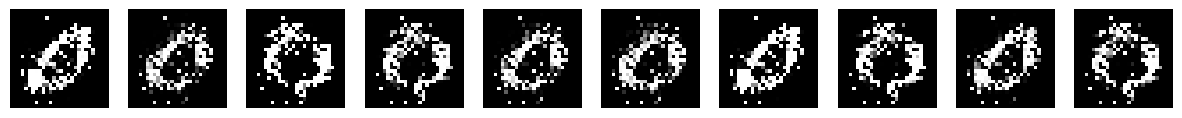

Epoch 61; Discriminator: 1.127, Generator: 0.906


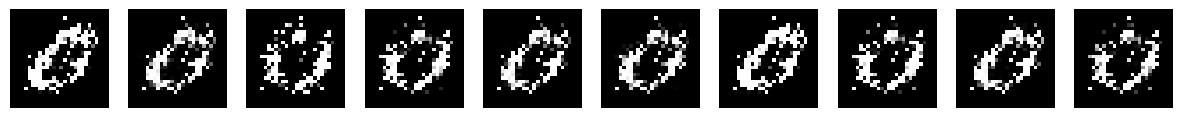

Epoch 62; Discriminator: 1.039, Generator: 0.867


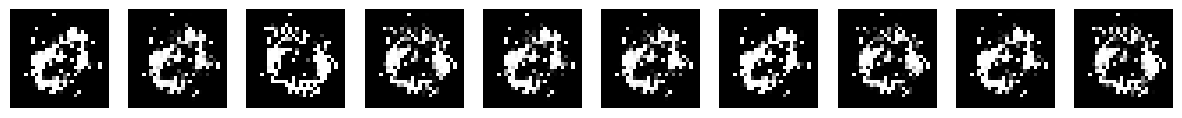

Epoch 63; Discriminator: 1.182, Generator: 0.914


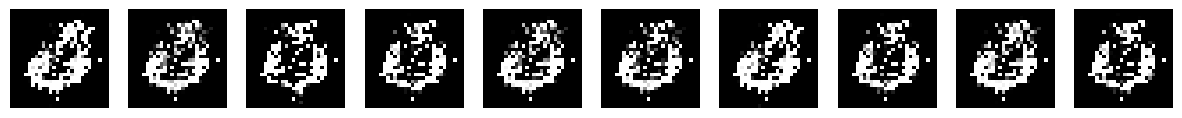

Epoch 64; Discriminator: 1.340, Generator: 0.919


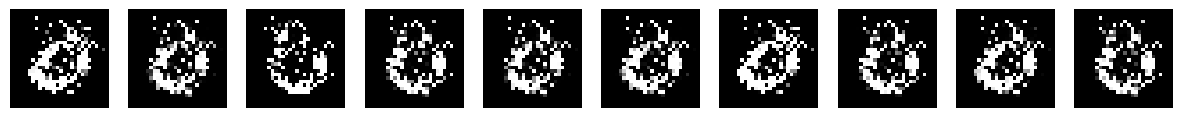

Epoch 65; Discriminator: 1.226, Generator: 0.984


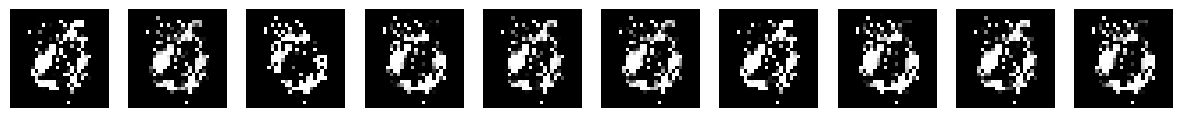

Epoch 66; Discriminator: 1.056, Generator: 1.082


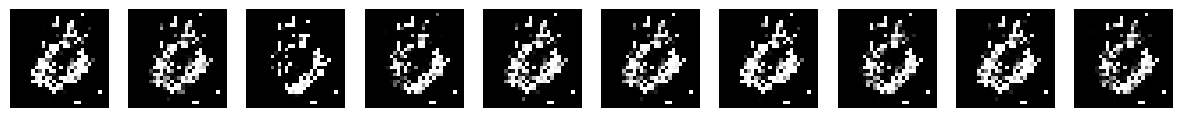

Epoch 67; Discriminator: 1.198, Generator: 0.959


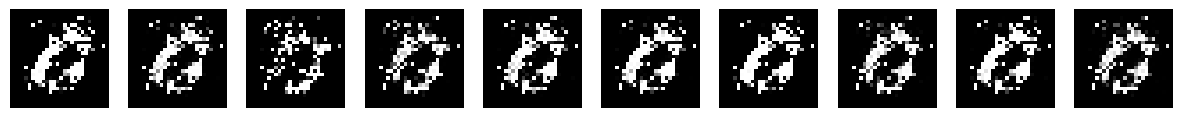

Epoch 68; Discriminator: 1.272, Generator: 0.907


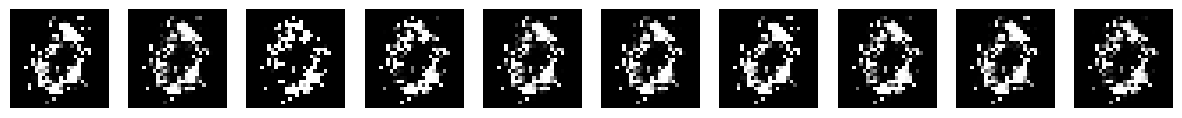

Epoch 69; Discriminator: 1.286, Generator: 0.860


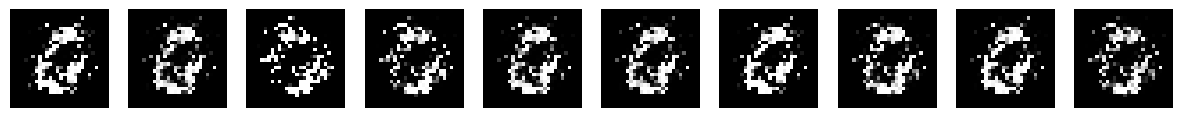

Epoch 70; Discriminator: 1.411, Generator: 0.820


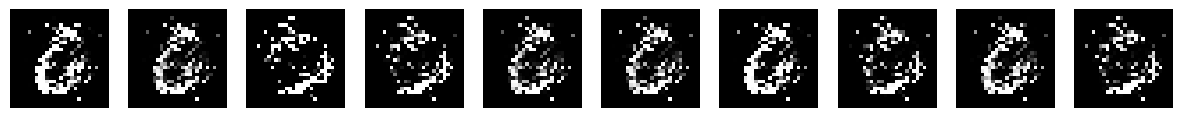

Epoch 71; Discriminator: 1.390, Generator: 0.809


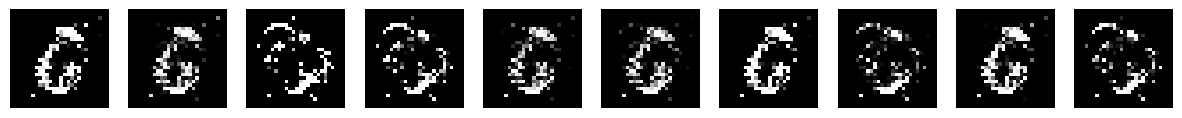

Epoch 72; Discriminator: 1.330, Generator: 0.731


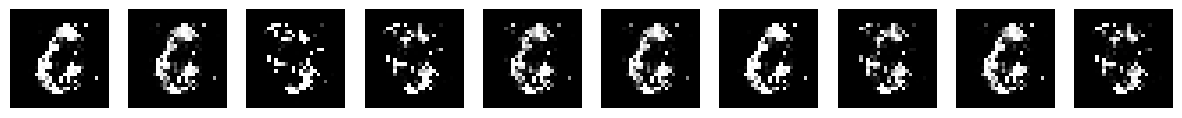

Epoch 73; Discriminator: 1.366, Generator: 0.760


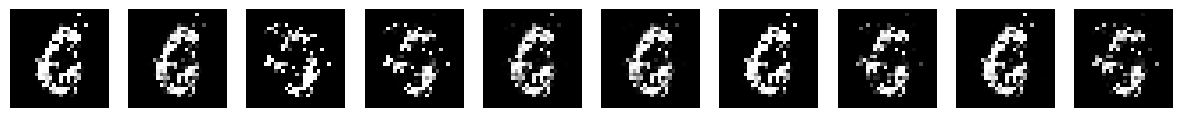

Epoch 74; Discriminator: 1.339, Generator: 0.695


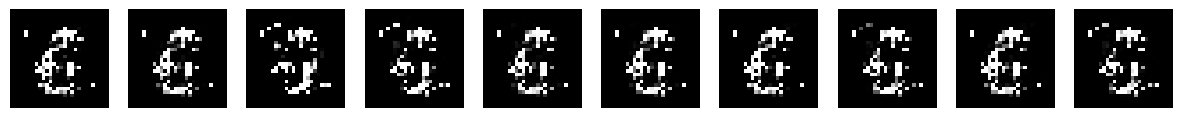

Epoch 75; Discriminator: 1.349, Generator: 0.763


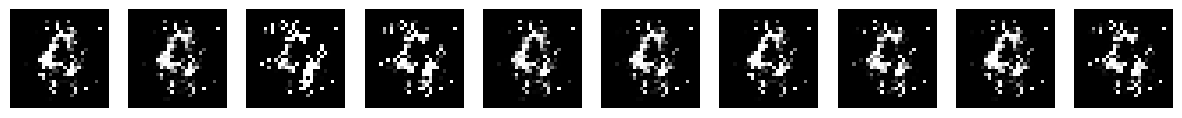

Epoch 76; Discriminator: 1.300, Generator: 0.772


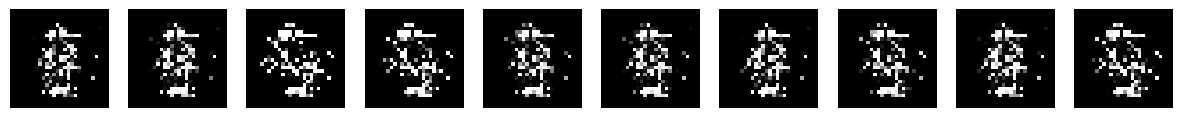

Epoch 77; Discriminator: 0.968, Generator: 0.920


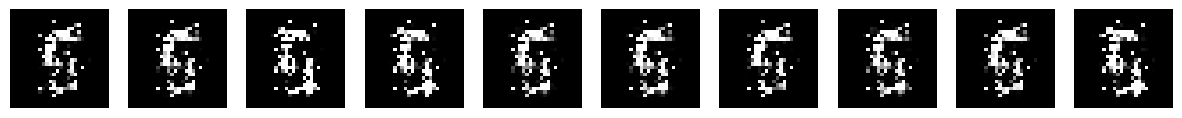

Epoch 78; Discriminator: 1.103, Generator: 0.885


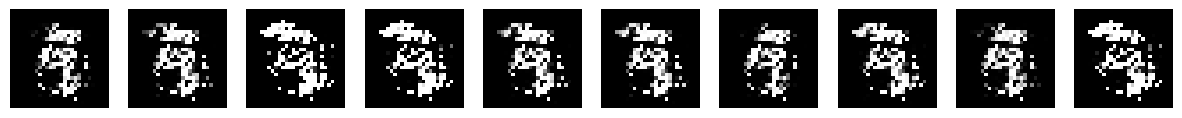

Epoch 79; Discriminator: 1.317, Generator: 0.805


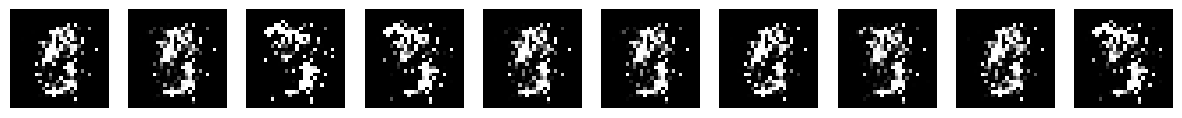

Epoch 80; Discriminator: 1.361, Generator: 0.843


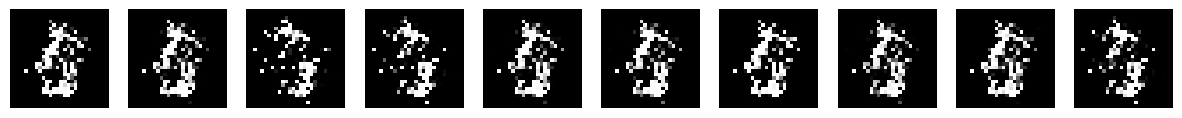

Epoch 81; Discriminator: 1.325, Generator: 0.768


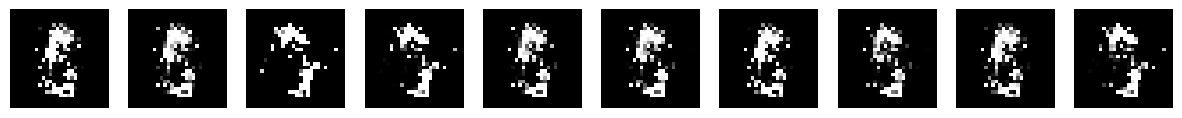

Epoch 82; Discriminator: 1.240, Generator: 0.889


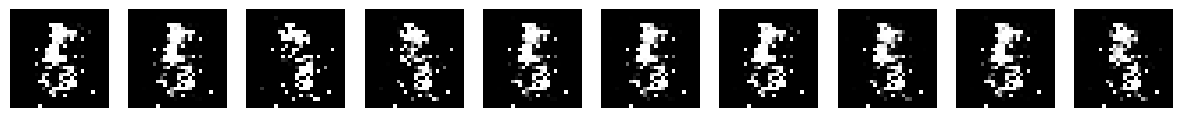

Epoch 83; Discriminator: 1.099, Generator: 1.039


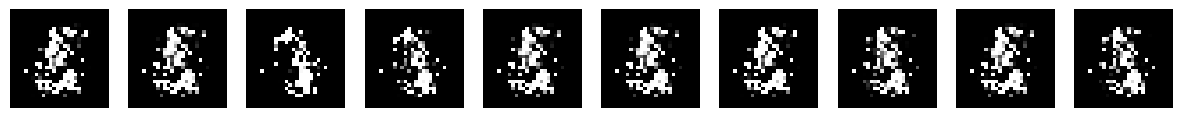

Epoch 84; Discriminator: 1.066, Generator: 1.232


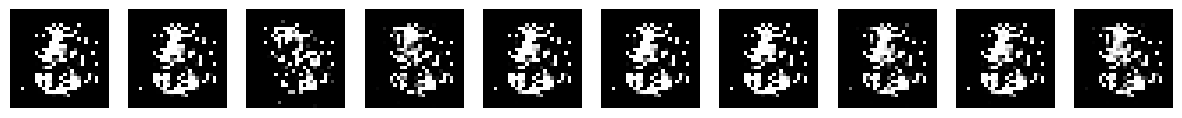

Epoch 85; Discriminator: 1.256, Generator: 1.009


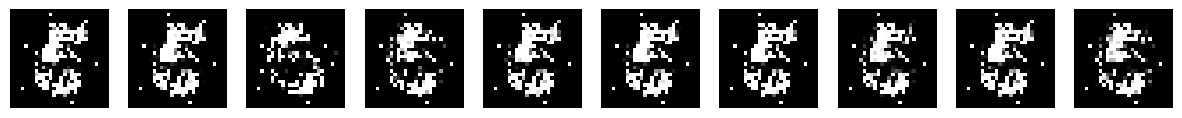

Epoch 86; Discriminator: 1.368, Generator: 0.858


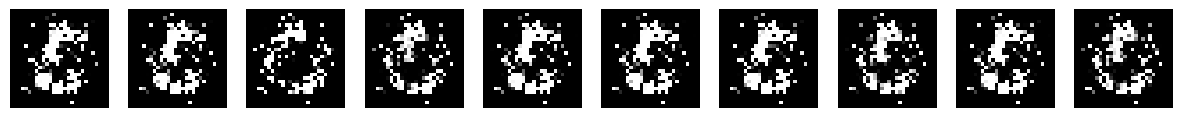

Epoch 87; Discriminator: 1.376, Generator: 0.805


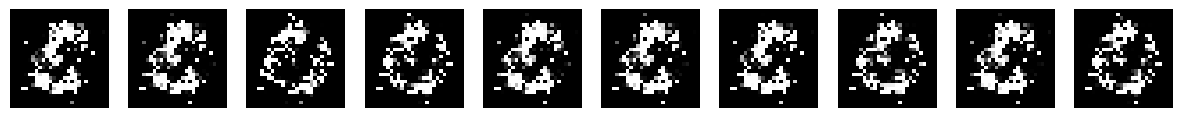

Epoch 88; Discriminator: 1.381, Generator: 0.778


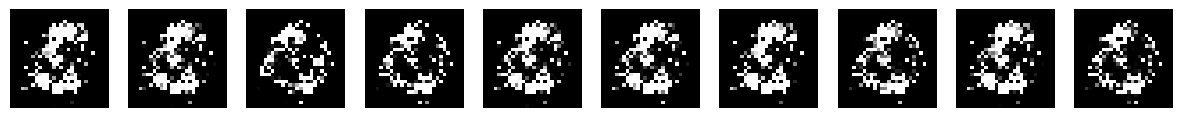

Epoch 89; Discriminator: 1.359, Generator: 0.753


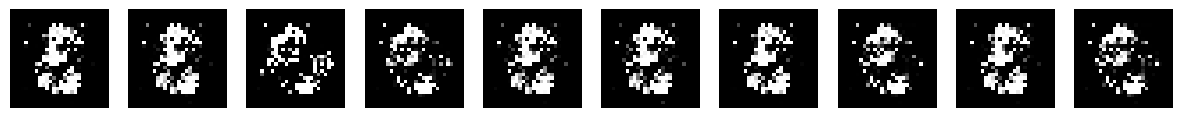

Epoch 90; Discriminator: 1.373, Generator: 0.741


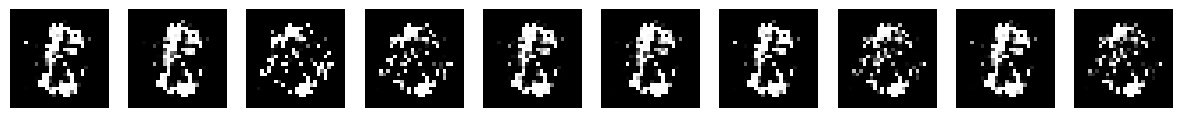

Epoch 91; Discriminator: 1.336, Generator: 0.732


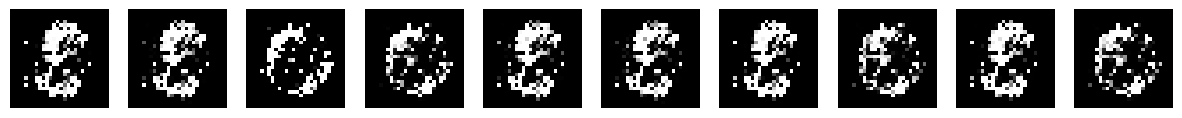

Epoch 92; Discriminator: 1.349, Generator: 0.744


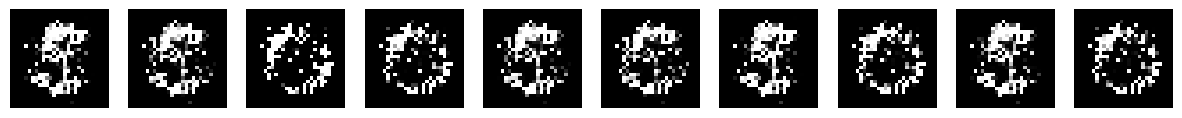

Epoch 93; Discriminator: 1.234, Generator: 0.773


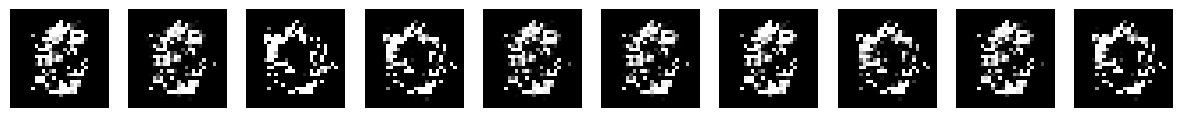

Epoch 94; Discriminator: 1.045, Generator: 0.944


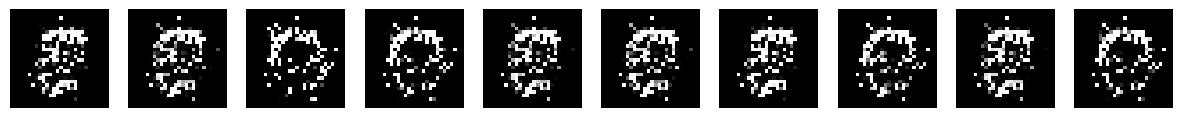

Epoch 95; Discriminator: 1.139, Generator: 0.838


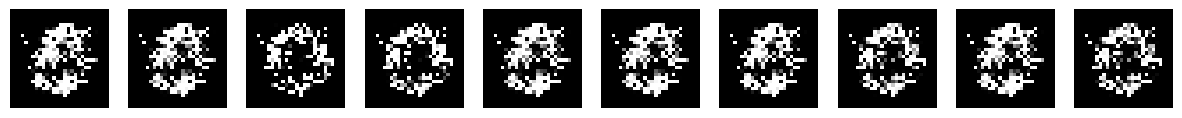

Epoch 96; Discriminator: 1.272, Generator: 0.923


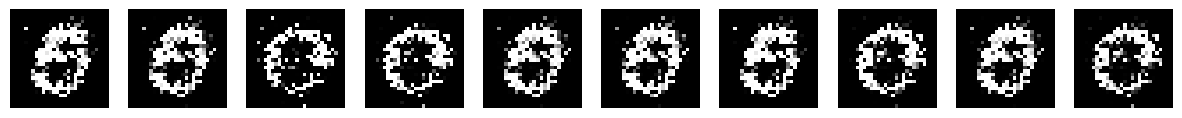

Epoch 97; Discriminator: 1.358, Generator: 0.794


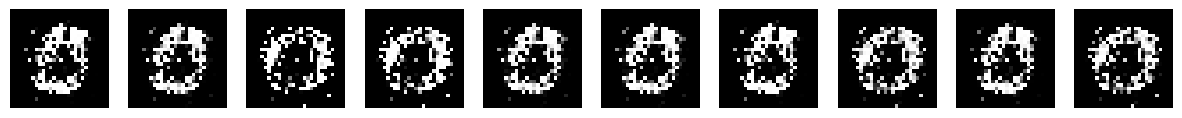

Epoch 98; Discriminator: 1.369, Generator: 0.800


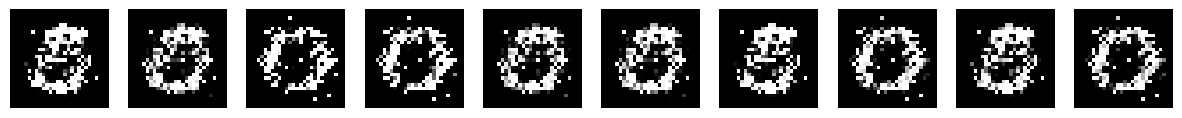

Epoch 99; Discriminator: 1.284, Generator: 0.756


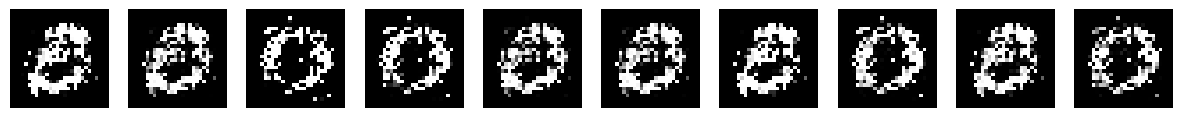

In [19]:
# Générer un z de la taille 10 x hidden_dimension
z_display = torch.randn(10, hidden_dim)

# Mettre le générateur et le discriminateur sur le dispositif
generator.to(device)
discriminator.to(device)

# Boucle d'apprentissage
for epoch in trange(100):
    for real_data, labels in mnist_loader:
        # Réinitialiser les gradients
        G_optimizer.zero_grad()
        D_optimizer.zero_grad()

        batch_size = real_data.size(0)

        # Convertir les données et les labels sur le dispositif
        real_data, labels = real_data.to(device), labels.to(device)

        # One-hot encode les labels
        one_hot_labels = F.one_hot(labels, num_classes=label_dim).float().to(device)

        #######################
        # Entraînement du Discriminateur
        #######################

        # Calculer la sortie du discriminateur pour les vraies données
        outputs_real = discriminator(torch.cat((real_data.view(batch_size, -1), one_hot_labels), dim=1))

        # Générer des données synthétiques avec le générateur
        z = torch.randn(batch_size, hidden_dim).to(device)
        generated_data = generator(torch.cat((z, one_hot_labels), dim=1))

        # Calculer la sortie du discriminateur pour les données générées
        outputs_generated = discriminator(torch.cat((generated_data, one_hot_labels), dim=1))

        # Calculer la fonction de coût pour le discriminateur
        D_loss = -torch.mean(torch.log(outputs_real + 1e-8) + torch.log(1 - outputs_generated + 1e-8))

        # Rétropropagation et mise à jour des poids du discriminateur
        D_loss.backward()
        D_optimizer.step()

        #######################
        # Entraînement du Générateur
        #######################

        # Réinitialiser les gradients du générateur
        G_optimizer.zero_grad()

        # Générer à nouveau des données avec le générateur
        generated_data = generator(torch.cat((z, one_hot_labels), dim=1))

        # Calculer la sortie du discriminateur pour les données générées
        outputs_generated = discriminator(torch.cat((generated_data, one_hot_labels), dim=1))

        # Calculer la fonction de coût pour le générateur
        G_loss = -torch.mean(torch.log(outputs_generated + 1e-8))

        # Rétropropagation et mise à jour des poids du générateur
        G_loss.backward()
        G_optimizer.step()

    # Afficher les résultats après chaque epoch
    tqdm.write(f"Epoch {epoch}; Discriminator: {D_loss.item():.3f}, Generator: {G_loss.item():.3f}")

    # Afficher les images générées avec le générateur pour z_display
    plot_images(generator, z_display)


---
<span style='color:Green'>**Question**</span>

Une fois le modèle entraîné, utiliser la fonction ‘plot_images‘ pour générer différents chiffres puis conclure

**Note :** Vous pouvez adapter le nombre d'epoch plus haut pour avoir de meilleurs résultats

---

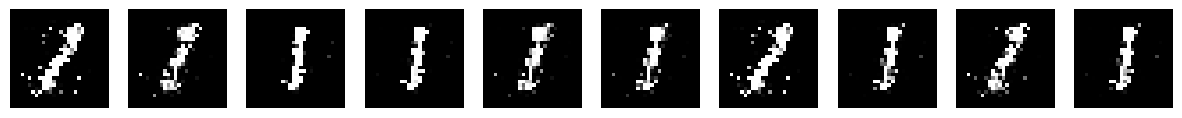

In [26]:
plot_images(generator,z_display,digit=1)
# essayer de changer les hyperparamètres pour améliorer les performances